### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints/'
summaries_path = cur_dir + 'summaries/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 2
    k = 0
    split = []
    task_weights = []
    while (k < num_class):
        split.append(list(range(k, k + class_per_task)))
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 49
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True, 
                                                        equal_weights=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/8, validation accuracies: [0.55000001], average train loss: 1.358725, average train accuracy: 0.525391
epoch: 2, iter: 0/8, validation accuracies: [0.5], average train loss: 0.694886, average train accuracy: 0.585938
epoch: 3, iter: 0/8, validation accuracies: [0.52499998], average train loss: 0.457584, average train accuracy: 0.815430
epoch: 4, iter: 0/8, validation accuracies: [0.72500002], average train loss: 0.400093, average train accuracy: 0.820312
epoch: 5, iter: 0/8, validation accuracies: [0.82499999], average train loss: 0.408311, average train accuracy: 0.816406
epoch: 6, iter: 0/8, validation accuracies: [0.82499999], average train loss: 0.343773, average train accuracy: 0.850586
epoch: 7, iter: 0/8, validation accuracies: [0.875], average train loss: 0.324144, average train accuracy: 0.856445
epo

epoch: 66, iter: 0/8, validation accuracies: [0.94999999], average train loss: 0.067868, average train accuracy: 0.973633
epoch: 67, iter: 0/8, validation accuracies: [0.94999999], average train loss: 0.060071, average train accuracy: 0.975586
epoch: 68, iter: 0/8, validation accuracies: [0.97500002], average train loss: 0.067338, average train accuracy: 0.969727
epoch: 69, iter: 0/8, validation accuracies: [0.94999999], average train loss: 0.066003, average train accuracy: 0.975586
epoch: 70, iter: 0/8, validation accuracies: [0.94999999], average train loss: 0.049021, average train accuracy: 0.980469
epochs: 70.000000, final train loss: 0.044021, validation accuracies: [0.94999999]
best epochs: 15.000000, best_avg: 1.000000, validation accuracies: [1.]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0 at time step 560
calculating penultimate output...
time taken: %f 0.3687469959259033
saving penu

epoch: 51, iter: 0/8, validation accuracies: [0.92500001 0.875     ], average train loss: 0.236830, average train accuracy: 0.916016
epoch: 52, iter: 0/8, validation accuracies: [0.89999998 0.92500001], average train loss: 0.228849, average train accuracy: 0.924805
epoch: 53, iter: 0/8, validation accuracies: [0.89999998 0.92500001], average train loss: 0.204350, average train accuracy: 0.928711
epoch: 54, iter: 0/8, validation accuracies: [0.94999999 0.92500001], average train loss: 0.219985, average train accuracy: 0.908203
epoch: 55, iter: 0/8, validation accuracies: [0.92500001 0.94999999], average train loss: 0.227808, average train accuracy: 0.918945
epoch: 56, iter: 0/8, validation accuracies: [0.92500001 0.89999998], average train loss: 0.211730, average train accuracy: 0.924805
epoch: 57, iter: 0/8, validation accuracies: [0.92500001 0.89999998], average train loss: 0.245009, average train accuracy: 0.917969
epoch: 58, iter: 0/8, validation accuracies: [0.89999998 0.875     ],

epoch: 32, iter: 0/8, validation accuracies: [0.875      0.69999999 0.69999999], average train loss: 0.624487, average train accuracy: 0.771484
epoch: 33, iter: 0/8, validation accuracies: [0.875      0.60000002 0.82499999], average train loss: 0.588523, average train accuracy: 0.791016
epoch: 34, iter: 0/8, validation accuracies: [0.875      0.85000002 0.55000001], average train loss: 0.566434, average train accuracy: 0.780273
epoch: 35, iter: 0/8, validation accuracies: [0.82499999 0.92500001 0.52499998], average train loss: 0.584469, average train accuracy: 0.779297
epoch: 36, iter: 0/8, validation accuracies: [0.85000002 0.52499998 0.75      ], average train loss: 0.542971, average train accuracy: 0.782227
epoch: 37, iter: 0/8, validation accuracies: [0.85000002 0.77499998 0.64999998], average train loss: 0.536051, average train accuracy: 0.793945
epoch: 37, iter: 4/8, loss: 0.474282, accuracy: 0.804688
epoch: 38, iter: 0/8, validation accuracies: [0.85000002 0.80000001 0.57499999]

epoch: 11, iter: 0/8, validation accuracies: [0.85000002 0.55000001 0.60000002 0.52499998], average train loss: 0.810262, average train accuracy: 0.717773
epoch: 12, iter: 0/8, validation accuracies: [0.89999998 0.5        0.77499998 0.52499998], average train loss: 0.819407, average train accuracy: 0.709961
epoch: 12, iter: 4/8, loss: 0.876904, accuracy: 0.671875
epoch: 13, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.52499998 0.55000001], average train loss: 0.861794, average train accuracy: 0.684570
epoch: 14, iter: 0/8, validation accuracies: [0.89999998 0.92500001 0.40000001 0.44999999], average train loss: 0.847927, average train accuracy: 0.708008
epoch: 15, iter: 0/8, validation accuracies: [0.80000001 0.625      0.64999998 0.67500001], average train loss: 0.731986, average train accuracy: 0.723633
epoch: 16, iter: 0/8, validation accuracies: [0.92500001 0.85000002 0.25       0.30000001], average train loss: 0.729047, average train accuracy: 0.749023
epoch: 17, it

epoch: 62, iter: 4/8, loss: 0.301860, accuracy: 0.929688
epoch: 63, iter: 0/8, validation accuracies: [0.875      0.72500002 0.80000001 0.69999999], average train loss: 0.335086, average train accuracy: 0.888672
epoch: 64, iter: 0/8, validation accuracies: [0.875      0.69999999 0.82499999 0.69999999], average train loss: 0.291572, average train accuracy: 0.897461
epoch: 65, iter: 0/8, validation accuracies: [0.89999998 0.75       0.82499999 0.67500001], average train loss: 0.307879, average train accuracy: 0.889648
epoch: 66, iter: 0/8, validation accuracies: [0.89999998 0.75       0.82499999 0.67500001], average train loss: 0.292215, average train accuracy: 0.898438
epoch: 67, iter: 0/8, validation accuracies: [0.89999998 0.72500002 0.80000001 0.64999998], average train loss: 0.259813, average train accuracy: 0.910156
epoch: 68, iter: 0/8, validation accuracies: [0.89999998 0.72500002 0.80000001 0.64999998], average train loss: 0.267013, average train accuracy: 0.907227
epoch: 69, it

epoch: 36, iter: 0/8, validation accuracies: [0.80000001 0.75       0.77499998 0.52499998 0.69999999], average train loss: 0.562896, average train accuracy: 0.814453
epoch: 37, iter: 0/8, validation accuracies: [0.80000001 0.69999999 0.72500002 0.77499998 0.64999998], average train loss: 0.472876, average train accuracy: 0.832031
epoch: 37, iter: 4/8, loss: 0.422946, accuracy: 0.812500
epoch: 38, iter: 0/8, validation accuracies: [0.89999998 0.55000001 0.77499998 0.64999998 0.75      ], average train loss: 0.494637, average train accuracy: 0.833984
epoch: 39, iter: 0/8, validation accuracies: [0.69999999 0.625      0.72500002 0.60000002 0.72500002], average train loss: 0.504545, average train accuracy: 0.831055
epoch: 40, iter: 0/8, validation accuracies: [0.80000001 0.85000002 0.60000002 0.64999998 0.57499999], average train loss: 0.495954, average train accuracy: 0.832031
epoch: 41, iter: 0/8, validation accuracies: [0.82499999 0.57499999 0.67500001 0.72500002 0.57499999], average tr

epoch: 8, iter: 0/8, validation accuracies: [0.77499998 0.44999999 0.60000002 0.72500002 0.69999999 0.2       ], average train loss: 0.752643, average train accuracy: 0.725586
epoch: 9, iter: 0/8, validation accuracies: [0.82499999 0.625      0.80000001 0.69999999 0.67500001 0.34999999], average train loss: 0.798338, average train accuracy: 0.730469
epoch: 10, iter: 0/8, validation accuracies: [0.89999998 0.72500002 0.57499999 0.55000001 0.625      0.175     ], average train loss: 0.775047, average train accuracy: 0.725586
epoch: 11, iter: 0/8, validation accuracies: [0.69999999 0.42500001 0.47499999 0.64999998 0.44999999 0.5       ], average train loss: 0.795667, average train accuracy: 0.716797
epoch: 12, iter: 0/8, validation accuracies: [0.77499998 0.625      0.64999998 0.72500002 0.82499999 0.32499999], average train loss: 0.703768, average train accuracy: 0.742188
epoch: 12, iter: 4/8, loss: 0.666701, accuracy: 0.804688
epoch: 13, iter: 0/8, validation accuracies: [0.875      0.7

epoch: 54, iter: 0/8, validation accuracies: [0.875      0.69999999 0.72500002 0.67500001 0.75       0.52499998], average train loss: 0.362510, average train accuracy: 0.876953
epoch: 55, iter: 0/8, validation accuracies: [0.85000002 0.57499999 0.75       0.75       0.75       0.47499999], average train loss: 0.434200, average train accuracy: 0.855469
epoch: 56, iter: 0/8, validation accuracies: [0.85000002 0.52499998 0.85000002 0.75       0.75       0.52499998], average train loss: 0.362422, average train accuracy: 0.868164
epoch: 57, iter: 0/8, validation accuracies: [0.875      0.72500002 0.75       0.75       0.80000001 0.5       ], average train loss: 0.375779, average train accuracy: 0.864258
epoch: 58, iter: 0/8, validation accuracies: [0.82499999 0.72500002 0.67500001 0.77499998 0.72500002 0.52499998], average train loss: 0.338555, average train accuracy: 0.875977
epoch: 59, iter: 0/8, validation accuracies: [0.875      0.64999998 0.80000001 0.77499998 0.69999999 0.5       ], a

epoch: 23, iter: 0/8, validation accuracies: [0.85000002 0.64999998 0.60000002 0.5        0.625      0.64999998
 0.57499999], average train loss: 0.569610, average train accuracy: 0.817383
epoch: 24, iter: 0/8, validation accuracies: [0.77499998 0.55000001 0.69999999 0.69999999 0.72500002 0.42500001
 0.69999999], average train loss: 0.523523, average train accuracy: 0.829102
epoch: 25, iter: 0/8, validation accuracies: [0.75       0.5        0.75       0.67500001 0.72500002 0.52499998
 0.52499998], average train loss: 0.589633, average train accuracy: 0.796875
epoch: 25, iter: 0/8, loss: 0.656078, accuracy: 0.773438
epoch: 26, iter: 0/8, validation accuracies: [0.85000002 0.77499998 0.625      0.57499999 0.30000001 0.55000001
 0.69999999], average train loss: 0.601535, average train accuracy: 0.804688
epoch: 27, iter: 0/8, validation accuracies: [0.77499998 0.44999999 0.875      0.64999998 0.75       0.42500001
 0.57499999], average train loss: 0.542621, average train accuracy: 0.82324

epoch: 66, iter: 0/8, validation accuracies: [0.85000002 0.72500002 0.89999998 0.77499998 0.82499999 0.60000002
 0.72500002], average train loss: 0.258949, average train accuracy: 0.912109
epoch: 67, iter: 0/8, validation accuracies: [0.85000002 0.72500002 0.875      0.80000001 0.82499999 0.60000002
 0.72500002], average train loss: 0.274539, average train accuracy: 0.908203
epoch: 68, iter: 0/8, validation accuracies: [0.85000002 0.69999999 0.875      0.77499998 0.85000002 0.60000002
 0.72500002], average train loss: 0.259606, average train accuracy: 0.920898
epoch: 69, iter: 0/8, validation accuracies: [0.85000002 0.69999999 0.85000002 0.80000001 0.85000002 0.625
 0.72500002], average train loss: 0.271698, average train accuracy: 0.918945
epoch: 70, iter: 0/8, validation accuracies: [0.85000002 0.69999999 0.85000002 0.77499998 0.82499999 0.60000002
 0.69999999], average train loss: 0.284033, average train accuracy: 0.897461
epochs: 70.000000, final train loss: 0.208040, validation ac

epoch: 32, iter: 0/8, validation accuracies: [0.92500001 0.72500002 0.55000001 0.55000001 0.69999999 0.44999999
 0.60000002 0.625     ], average train loss: 0.584630, average train accuracy: 0.799805
epoch: 33, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.57499999 0.64999998 0.57499999 0.55000001
 0.625      0.64999998], average train loss: 0.599253, average train accuracy: 0.795898
epoch: 34, iter: 0/8, validation accuracies: [0.89999998 0.5        0.57499999 0.60000002 0.64999998 0.625
 0.72500002 0.625     ], average train loss: 0.574821, average train accuracy: 0.806641
epoch: 35, iter: 0/8, validation accuracies: [0.89999998 0.64999998 0.77499998 0.64999998 0.67500001 0.32499999
 0.625      0.625     ], average train loss: 0.532370, average train accuracy: 0.817383
epoch: 36, iter: 0/8, validation accuracies: [0.75       0.625      0.67500001 0.77499998 0.80000001 0.57499999
 0.64999998 0.72500002], average train loss: 0.561324, average train accuracy: 0.809570
epoch

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=7 at time step 560
calculating penultimate output...
time taken: %f 0.7025244235992432
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=8
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=7
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=7.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.875      0.64999998 0.80000001 0.64999998 0.5        0.55000001
 0.55000001 0.77499998 0.025     ], average train loss: 0.932076, average train accuracy: 0.777344
epoch: 2, iter: 0/8, validation a

epoch: 36, iter: 0/8, validation accuracies: [0.82499999 0.625      0.64999998 0.80000001 0.60000002 0.64999998
 0.60000002 0.625      0.52499998], average train loss: 0.505854, average train accuracy: 0.840820
epoch: 37, iter: 0/8, validation accuracies: [0.69999999 0.72500002 0.625      0.52499998 0.60000002 0.55000001
 0.60000002 0.72500002 0.52499998], average train loss: 0.477832, average train accuracy: 0.843750
epoch: 37, iter: 4/8, loss: 0.529245, accuracy: 0.851562
epoch: 38, iter: 0/8, validation accuracies: [0.82499999 0.625      0.75       0.75       0.625      0.44999999
 0.60000002 0.52499998 0.375     ], average train loss: 0.557482, average train accuracy: 0.818359
epoch: 39, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.69999999 0.60000002 0.82499999 0.47499999
 0.55000001 0.60000002 0.57499999], average train loss: 0.592732, average train accuracy: 0.812500
epoch: 40, iter: 0/8, validation accuracies: [0.82499999 0.60000002 0.75       0.85000002 0.6750000

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=8
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=8.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.89999998 0.57499999 0.69999999 0.67500001 0.82499999 0.40000001
 0.60000002 0.69999999 0.72500002 0.        ], average train loss: 0.841231, average train accuracy: 0.806641
epoch: 2, iter: 0/8, validation accuracies: [0.72500002 0.55000001 0.69999999 0.75       0.60000002 0.52499998
 0.47499999 0.72500002 0.64999998 0.34999999], average train loss: 0.714275, average train accuracy: 0.779297
epoch: 3, iter: 0/8, validation accuracies: [0.69999999 0.5        0.64999998 0.57499999 0.72500002 0.625
 0.57499999 0.52499998 0.80000001 0.125     ], average train loss: 0.676856, average train accuracy: 0.792969


epoch: 37, iter: 0/8, validation accuracies: [0.92500001 0.57499999 0.72500002 0.69999999 0.625      0.44999999
 0.47499999 0.57499999 0.67500001 0.40000001], average train loss: 0.602326, average train accuracy: 0.799805
epoch: 37, iter: 4/8, loss: 0.559164, accuracy: 0.781250
epoch: 38, iter: 0/8, validation accuracies: [0.80000001 0.625      0.55000001 0.60000002 0.625      0.55000001
 0.60000002 0.72500002 0.69999999 0.375     ], average train loss: 0.600114, average train accuracy: 0.794922
epoch: 39, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.40000001 0.625      0.57499999 0.47499999
 0.75       0.52499998 0.69999999 0.57499999], average train loss: 0.668070, average train accuracy: 0.788086
epoch: 40, iter: 0/8, validation accuracies: [0.80000001 0.67500001 0.67500001 0.57499999 0.625      0.42500001
 0.64999998 0.75       0.75       0.42500001], average train loss: 0.630672, average train accuracy: 0.796875
epoch: 41, iter: 0/8, validation accuracies: [0.8999999

time taken: %f 0.8973617553710938
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=9
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=9.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.89999998 0.625      0.57499999 0.77499998 0.75       0.52499998
 0.67500001 0.67500001 0.875      0.55000001 0.        ], average train loss: 0.867537, average train accuracy: 0.800781
epoch: 2, iter: 0/8, validation accuracies: [0.80000001 0.60000002 0.55000001 0.57499999 0.69999999 0.42500001
 0.75       0.44999999 0.75       0.30000001 0.44999999], average train loss: 0.726119, a

epoch: 34, iter: 0/8, validation accuracies: [0.82499999 0.42500001 0.40000001 0.64999998 0.82499999 0.75
 0.60000002 0.57499999 0.69999999 0.55000001 0.67500001], average train loss: 0.586354, average train accuracy: 0.815430
epoch: 35, iter: 0/8, validation accuracies: [0.875      0.60000002 0.57499999 0.67500001 0.64999998 0.44999999
 0.52499998 0.625      0.69999999 0.55000001 0.625     ], average train loss: 0.586119, average train accuracy: 0.807617
epoch: 36, iter: 0/8, validation accuracies: [0.77499998 0.5        0.32499999 0.64999998 0.625      0.47499999
 0.57499999 0.64999998 0.80000001 0.5        0.85000002], average train loss: 0.536186, average train accuracy: 0.823242
epoch: 37, iter: 0/8, validation accuracies: [0.72500002 0.55000001 0.69999999 0.625      0.82499999 0.47499999
 0.67500001 0.55000001 0.72500002 0.52499998 0.77499998], average train loss: 0.558382, average train accuracy: 0.811523
epoch: 37, iter: 4/8, loss: 0.677871, accuracy: 0.750000
epoch: 38, iter: 

epoch: 69, iter: 0/8, validation accuracies: [0.89999998 0.67500001 0.80000001 0.72500002 0.80000001 0.64999998
 0.72500002 0.69999999 0.82499999 0.625      0.875     ], average train loss: 0.317347, average train accuracy: 0.889648
epoch: 70, iter: 0/8, validation accuracies: [0.89999998 0.64999998 0.77499998 0.72500002 0.80000001 0.64999998
 0.69999999 0.67500001 0.82499999 0.625      0.85000002], average train loss: 0.337973, average train accuracy: 0.898438
epochs: 70.000000, final train loss: 0.390640, validation accuracies: [0.89999998 0.64999998 0.77499998 0.72500002 0.80000001 0.64999998
 0.69999999 0.67500001 0.82499999 0.625      0.85000002]
best epochs: 69.000000, best_avg: 0.754545, validation accuracies: [0.89999998 0.67500001 0.80000001 0.72500002 0.80000001 0.64999998
 0.72500002 0.69999999 0.82499999 0.625      0.875     ]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10 at time s

epoch: 28, iter: 0/8, validation accuracies: [0.89999998 0.42500001 0.64999998 0.72500002 0.80000001 0.60000002
 0.55000001 0.42500001 0.57499999 0.55000001 0.69999999 0.82499999], average train loss: 0.641866, average train accuracy: 0.793945
epoch: 29, iter: 0/8, validation accuracies: [0.75       0.77499998 0.60000002 0.57499999 0.75       0.34999999
 0.625      0.77499998 0.75       0.47499999 0.77499998 0.77499998], average train loss: 0.562852, average train accuracy: 0.809570
epoch: 30, iter: 0/8, validation accuracies: [0.85000002 0.42500001 0.47499999 0.69999999 0.75       0.5
 0.625      0.625      0.64999998 0.60000002 0.89999998 0.77499998], average train loss: 0.602801, average train accuracy: 0.795898
epoch: 31, iter: 0/8, validation accuracies: [0.92500001 0.625      0.40000001 0.82499999 0.80000001 0.32499999
 0.625      0.77499998 0.52499998 0.42500001 0.64999998 0.67500001], average train loss: 0.528799, average train accuracy: 0.833008
epoch: 32, iter: 0/8, validatio

epoch: 62, iter: 0/8, validation accuracies: [0.89999998 0.69999999 0.75       0.69999999 0.82499999 0.60000002
 0.64999998 0.72500002 0.77499998 0.625      0.82499999 0.85000002], average train loss: 0.366177, average train accuracy: 0.891602
epoch: 62, iter: 4/8, loss: 0.289152, accuracy: 0.906250
epoch: 63, iter: 0/8, validation accuracies: [0.85000002 0.67500001 0.77499998 0.67500001 0.82499999 0.52499998
 0.64999998 0.67500001 0.80000001 0.625      0.80000001 0.82499999], average train loss: 0.323251, average train accuracy: 0.888672
epoch: 64, iter: 0/8, validation accuracies: [0.85000002 0.67500001 0.72500002 0.67500001 0.85000002 0.52499998
 0.625      0.72500002 0.80000001 0.60000002 0.80000001 0.82499999], average train loss: 0.342433, average train accuracy: 0.893555
epoch: 65, iter: 0/8, validation accuracies: [0.89999998 0.69999999 0.72500002 0.67500001 0.82499999 0.55000001
 0.625      0.72500002 0.77499998 0.60000002 0.80000001 0.82499999], average train loss: 0.343361, 

epoch: 20, iter: 0/8, validation accuracies: [0.82499999 0.75       0.77499998 0.625      0.69999999 0.52499998
 0.64999998 0.47499999 0.77499998 0.52499998 0.85000002 0.77499998
 0.47499999], average train loss: 0.615188, average train accuracy: 0.791992
epoch: 21, iter: 0/8, validation accuracies: [0.55000001 0.34999999 0.57499999 0.625      0.60000002 0.52499998
 0.72500002 0.57499999 0.67500001 0.40000001 0.94999999 0.77499998
 0.375     ], average train loss: 0.629726, average train accuracy: 0.778320
epoch: 22, iter: 0/8, validation accuracies: [0.94999999 0.42500001 0.57499999 0.67500001 0.67500001 0.57499999
 0.5        0.625      0.69999999 0.52499998 0.72500002 0.82499999
 0.625     ], average train loss: 0.588309, average train accuracy: 0.800781
epoch: 23, iter: 0/8, validation accuracies: [0.85000002 0.5        0.625      0.67500001 0.60000002 0.60000002
 0.60000002 0.64999998 0.80000001 0.52499998 0.69999999 0.77499998
 0.47499999], average train loss: 0.565118, average t

epoch: 52, iter: 0/8, validation accuracies: [0.89999998 0.55000001 0.67500001 0.69999999 0.80000001 0.5
 0.64999998 0.67500001 0.80000001 0.625      0.875      0.85000002
 0.5       ], average train loss: 0.478596, average train accuracy: 0.843750
epoch: 53, iter: 0/8, validation accuracies: [0.89999998 0.55000001 0.67500001 0.72500002 0.80000001 0.55000001
 0.67500001 0.69999999 0.80000001 0.625      0.89999998 0.85000002
 0.5       ], average train loss: 0.406119, average train accuracy: 0.867188
epoch: 54, iter: 0/8, validation accuracies: [0.89999998 0.55000001 0.64999998 0.72500002 0.80000001 0.55000001
 0.64999998 0.72500002 0.82499999 0.60000002 0.875      0.875
 0.42500001], average train loss: 0.379880, average train accuracy: 0.883789
epoch: 55, iter: 0/8, validation accuracies: [0.875      0.57499999 0.67500001 0.67500001 0.77499998 0.5
 0.67500001 0.72500002 0.82499999 0.57499999 0.875      0.85000002
 0.47499999], average train loss: 0.408734, average train accuracy: 0.86

epoch: 9, iter: 0/8, validation accuracies: [0.80000001 0.57499999 0.69999999 0.57499999 0.72500002 0.47499999
 0.60000002 0.77499998 0.72500002 0.375      0.72500002 0.82499999
 0.57499999 0.175     ], average train loss: 0.687570, average train accuracy: 0.777344
epoch: 10, iter: 0/8, validation accuracies: [0.89999998 0.75       0.5        0.57499999 0.5        0.44999999
 0.625      0.64999998 0.625      0.64999998 0.82499999 0.60000002
 0.57499999 0.34999999], average train loss: 0.703513, average train accuracy: 0.758789
epoch: 11, iter: 0/8, validation accuracies: [0.80000001 0.60000002 0.625      0.55000001 0.57499999 0.32499999
 0.69999999 0.60000002 0.72500002 0.32499999 0.72500002 0.77499998
 0.5        0.40000001], average train loss: 0.686166, average train accuracy: 0.777344
epoch: 12, iter: 0/8, validation accuracies: [0.80000001 0.57499999 0.64999998 0.60000002 0.60000002 0.42500001
 0.57499999 0.47499999 0.72500002 0.5        0.75       0.80000001
 0.44999999 0.3249999

epoch: 40, iter: 0/8, validation accuracies: [0.85000002 0.57499999 0.625      0.57499999 0.57499999 0.34999999
 0.55000001 0.72500002 0.77499998 0.52499998 0.92500001 0.82499999
 0.34999999 0.32499999], average train loss: 0.583881, average train accuracy: 0.821289
epoch: 41, iter: 0/8, validation accuracies: [0.82499999 0.77499998 0.47499999 0.60000002 0.52499998 0.5
 0.57499999 0.52499998 0.69999999 0.625      0.75       0.69999999
 0.60000002 0.32499999], average train loss: 0.639647, average train accuracy: 0.789062
epoch: 42, iter: 0/8, validation accuracies: [0.75       0.55000001 0.80000001 0.47499999 0.64999998 0.47499999
 0.625      0.625      0.75       0.47499999 0.75       0.77499998
 0.57499999 0.55000001], average train loss: 0.647848, average train accuracy: 0.790039
epoch: 43, iter: 0/8, validation accuracies: [0.82499999 0.67500001 0.625      0.69999999 0.57499999 0.55000001
 0.625      0.60000002 0.85000002 0.625      0.82499999 0.82499999
 0.44999999 0.40000001], av

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=13 at time step 560
calculating penultimate output...
time taken: %f 1.2361769676208496
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=14
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=13
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=13.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.85000002 0.72500002 0.55000001 0.67500001 0.72500002 0.40000001
 0.64999998 0.60000002 0.80000001 0.57499999 0.875      0.80000001
 0.625      0.55000001 0.        ], average train loss: 0.904

epoch: 28, iter: 0/8, validation accuracies: [0.89999998 0.52499998 0.625      0.60000002 0.82499999 0.42500001
 0.64999998 0.64999998 0.72500002 0.42500001 0.77499998 0.89999998
 0.52499998 0.625      0.52499998], average train loss: 0.692061, average train accuracy: 0.780273
epoch: 29, iter: 0/8, validation accuracies: [0.85000002 0.52499998 0.47499999 0.64999998 0.64999998 0.57499999
 0.625      0.75       0.69999999 0.64999998 0.77499998 0.80000001
 0.52499998 0.42500001 0.44999999], average train loss: 0.632667, average train accuracy: 0.805664
epoch: 30, iter: 0/8, validation accuracies: [0.89999998 0.85000002 0.40000001 0.44999999 0.75       0.34999999
 0.67500001 0.69999999 0.85000002 0.60000002 0.89999998 0.80000001
 0.42500001 0.25       0.44999999], average train loss: 0.631423, average train accuracy: 0.810547
epoch: 31, iter: 0/8, validation accuracies: [0.77499998 0.625      0.5        0.57499999 0.5        0.67500001
 0.67500001 0.52499998 0.75       0.64999998 0.875    

epoch: 58, iter: 0/8, validation accuracies: [0.875      0.67500001 0.69999999 0.625      0.80000001 0.5
 0.67500001 0.77499998 0.85000002 0.625      0.89999998 0.80000001
 0.57499999 0.57499999 0.625     ], average train loss: 0.430555, average train accuracy: 0.869141
epoch: 59, iter: 0/8, validation accuracies: [0.875      0.67500001 0.67500001 0.64999998 0.82499999 0.44999999
 0.64999998 0.80000001 0.82499999 0.5        0.92500001 0.80000001
 0.625      0.55000001 0.625     ], average train loss: 0.455679, average train accuracy: 0.852539
epoch: 60, iter: 0/8, validation accuracies: [0.875      0.625      0.67500001 0.60000002 0.77499998 0.44999999
 0.625      0.80000001 0.85000002 0.5        0.92500001 0.80000001
 0.67500001 0.55000001 0.67500001], average train loss: 0.466272, average train accuracy: 0.855469
epoch: 61, iter: 0/8, validation accuracies: [0.875      0.625      0.67500001 0.60000002 0.77499998 0.55000001
 0.64999998 0.77499998 0.875      0.55000001 0.875      0.800

epoch: 12, iter: 4/8, loss: 0.682068, accuracy: 0.796875
epoch: 13, iter: 0/8, validation accuracies: [0.875      0.34999999 0.57499999 0.67500001 0.77499998 0.5
 0.375      0.72500002 0.77499998 0.52499998 0.82499999 0.625
 0.57499999 0.57499999 0.42500001 0.625     ], average train loss: 0.666464, average train accuracy: 0.783203
epoch: 14, iter: 0/8, validation accuracies: [1.         0.67500001 0.42500001 0.64999998 0.625      0.42500001
 0.375      0.67500001 0.72500002 0.57499999 0.80000001 0.67500001
 0.625      0.42500001 0.42500001 0.57499999], average train loss: 0.678247, average train accuracy: 0.794922
epoch: 15, iter: 0/8, validation accuracies: [0.92500001 0.625      0.55000001 0.60000002 0.60000002 0.42500001
 0.625      0.40000001 0.67500001 0.47499999 0.89999998 0.82499999
 0.57499999 0.5        0.52499998 0.67500001], average train loss: 0.685738, average train accuracy: 0.777344
epoch: 16, iter: 0/8, validation accuracies: [0.75       0.67500001 0.55000001 0.625    

epoch: 41, iter: 0/8, validation accuracies: [0.97500002 0.82499999 0.5        0.64999998 0.75       0.40000001
 0.55000001 0.57499999 0.80000001 0.52499998 0.80000001 0.77499998
 0.60000002 0.52499998 0.42500001 0.75      ], average train loss: 0.654906, average train accuracy: 0.788086
epoch: 42, iter: 0/8, validation accuracies: [0.82499999 0.72500002 0.57499999 0.625      0.80000001 0.5
 0.64999998 0.40000001 0.80000001 0.47499999 0.875      0.72500002
 0.625      0.55000001 0.5        0.75      ], average train loss: 0.633864, average train accuracy: 0.802734
epoch: 43, iter: 0/8, validation accuracies: [0.77499998 0.5        0.69999999 0.67500001 0.85000002 0.42500001
 0.77499998 0.64999998 0.55000001 0.69999999 0.77499998 0.72500002
 0.55000001 0.625      0.55000001 0.77499998], average train loss: 0.651320, average train accuracy: 0.794922
epoch: 44, iter: 0/8, validation accuracies: [0.75       0.64999998 0.77499998 0.64999998 0.57499999 0.52499998
 0.64999998 0.64999998 0.774

epoch: 70, iter: 0/8, validation accuracies: [0.875      0.60000002 0.60000002 0.64999998 0.82499999 0.60000002
 0.67500001 0.69999999 0.80000001 0.64999998 0.875      0.85000002
 0.67500001 0.57499999 0.625      0.80000001], average train loss: 0.375040, average train accuracy: 0.880859
epochs: 70.000000, final train loss: 0.390588, validation accuracies: [0.875      0.60000002 0.60000002 0.64999998 0.82499999 0.60000002
 0.67500001 0.69999999 0.80000001 0.64999998 0.875      0.85000002
 0.67500001 0.57499999 0.625      0.80000001]
best epochs: 62.000000, best_avg: 0.720312, validation accuracies: [0.92500001 0.57499999 0.55000001 0.69999999 0.82499999 0.57499999
 0.67500001 0.75       0.80000001 0.625      0.875      0.875
 0.67500001 0.64999998 0.57499999 0.875     ]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=15 at time step 560
calculating penultimate output...
time taken: %f 1.41434502601

epoch: 24, iter: 0/8, validation accuracies: [0.77499998 0.72500002 0.67500001 0.52499998 0.60000002 0.625
 0.625      0.77499998 0.85000002 0.57499999 0.875      0.72500002
 0.57499999 0.5        0.44999999 0.75       0.47499999], average train loss: 0.732616, average train accuracy: 0.776367
epoch: 25, iter: 0/8, validation accuracies: [0.67500001 0.625      0.625      0.77499998 0.64999998 0.52499998
 0.57499999 0.72500002 0.80000001 0.60000002 0.80000001 0.89999998
 0.64999998 0.5        0.5        0.625      0.44999999], average train loss: 0.668403, average train accuracy: 0.791992
epoch: 25, iter: 0/8, loss: 0.741822, accuracy: 0.812500
epoch: 26, iter: 0/8, validation accuracies: [0.85000002 0.34999999 0.60000002 0.625      0.80000001 0.40000001
 0.55000001 0.80000001 0.72500002 0.42500001 0.875      0.85000002
 0.42500001 0.64999998 0.69999999 0.77499998 0.32499999], average train loss: 0.705325, average train accuracy: 0.783203
epoch: 27, iter: 0/8, validation accuracies: [0.

epoch: 51, iter: 0/8, validation accuracies: [0.875      0.625      0.60000002 0.75       0.80000001 0.42500001
 0.69999999 0.69999999 0.77499998 0.57499999 0.89999998 0.75
 0.625      0.57499999 0.57499999 0.67500001 0.60000002], average train loss: 0.632741, average train accuracy: 0.799805
epoch: 52, iter: 0/8, validation accuracies: [0.875      0.64999998 0.67500001 0.64999998 0.77499998 0.375
 0.69999999 0.69999999 0.77499998 0.60000002 0.89999998 0.80000001
 0.625      0.625      0.55000001 0.67500001 0.55000001], average train loss: 0.510002, average train accuracy: 0.837891
epoch: 53, iter: 0/8, validation accuracies: [0.875      0.69999999 0.67500001 0.625      0.77499998 0.34999999
 0.69999999 0.72500002 0.77499998 0.64999998 0.89999998 0.82499999
 0.60000002 0.625      0.57499999 0.72500002 0.5       ], average train loss: 0.509134, average train accuracy: 0.838867
epoch: 54, iter: 0/8, validation accuracies: [0.875      0.67500001 0.67500001 0.625      0.77499998 0.42500001

epoch: 5, iter: 0/8, validation accuracies: [0.89999998 0.64999998 0.42500001 0.64999998 0.85000002 0.40000001
 0.60000002 0.5        0.89999998 0.5        0.77499998 0.75
 0.60000002 0.30000001 0.55000001 0.85000002 0.52499998 0.15000001], average train loss: 0.791150, average train accuracy: 0.752930
epoch: 6, iter: 0/8, validation accuracies: [0.82499999 0.52499998 0.64999998 0.55000001 0.77499998 0.375
 0.67500001 0.64999998 0.875      0.40000001 0.77499998 0.80000001
 0.625      0.5        0.52499998 0.77499998 0.47499999 0.42500001], average train loss: 0.705169, average train accuracy: 0.776367
epoch: 7, iter: 0/8, validation accuracies: [0.875      0.47499999 0.52499998 0.60000002 0.85000002 0.47499999
 0.625      0.80000001 0.64999998 0.5        0.80000001 0.80000001
 0.625      0.67500001 0.44999999 0.64999998 0.55000001 0.025     ], average train loss: 0.741213, average train accuracy: 0.768555
epoch: 8, iter: 0/8, validation accuracies: [0.75       0.42500001 0.57499999 0.5

epoch: 32, iter: 0/8, validation accuracies: [0.85000002 0.44999999 0.57499999 0.67500001 0.64999998 0.47499999
 0.52499998 0.5        0.625      0.42500001 0.875      0.85000002
 0.625      0.52499998 0.60000002 0.57499999 0.42500001 0.2       ], average train loss: 0.712822, average train accuracy: 0.779297
epoch: 33, iter: 0/8, validation accuracies: [0.75       0.69999999 0.42500001 0.69999999 0.75       0.55000001
 0.60000002 0.57499999 0.67500001 0.42500001 0.80000001 0.67500001
 0.55000001 0.42500001 0.55000001 0.75       0.44999999 0.42500001], average train loss: 0.813557, average train accuracy: 0.748047
epoch: 34, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.72500002 0.64999998 0.80000001 0.44999999
 0.60000002 0.69999999 0.625      0.47499999 0.77499998 0.75
 0.47499999 0.57499999 0.67500001 0.64999998 0.40000001 0.27500001], average train loss: 0.768001, average train accuracy: 0.753906
epoch: 35, iter: 0/8, validation accuracies: [0.69999999 0.5        0.625

epoch: 59, iter: 0/8, validation accuracies: [0.92500001 0.625      0.67500001 0.57499999 0.80000001 0.40000001
 0.67500001 0.69999999 0.85000002 0.55000001 0.875      0.77499998
 0.625      0.625      0.64999998 0.75       0.57499999 0.375     ], average train loss: 0.484011, average train accuracy: 0.847656
epoch: 60, iter: 0/8, validation accuracies: [0.875      0.64999998 0.64999998 0.55000001 0.82499999 0.375
 0.64999998 0.67500001 0.85000002 0.55000001 0.92500001 0.80000001
 0.57499999 0.67500001 0.625      0.80000001 0.57499999 0.375     ], average train loss: 0.456209, average train accuracy: 0.844727
epoch: 61, iter: 0/8, validation accuracies: [0.92500001 0.625      0.64999998 0.57499999 0.82499999 0.44999999
 0.64999998 0.67500001 0.82499999 0.55000001 0.94999999 0.77499998
 0.625      0.60000002 0.625      0.77499998 0.60000002 0.34999999], average train loss: 0.551570, average train accuracy: 0.824219
epoch: 62, iter: 0/8, validation accuracies: [0.89999998 0.72500002 0.60

epoch: 11, iter: 0/8, validation accuracies: [0.80000001 0.44999999 0.55000001 0.60000002 0.57499999 0.42500001
 0.5        0.67500001 0.67500001 0.55000001 0.85000002 0.85000002
 0.625      0.67500001 0.60000002 0.69999999 0.47499999 0.375
 0.47499999], average train loss: 0.743880, average train accuracy: 0.771484
epoch: 12, iter: 0/8, validation accuracies: [0.89999998 0.82499999 0.64999998 0.60000002 0.72500002 0.25
 0.67500001 0.75       0.77499998 0.47499999 0.75       0.89999998
 0.55000001 0.55000001 0.52499998 0.64999998 0.55000001 0.42500001
 0.27500001], average train loss: 0.665359, average train accuracy: 0.797852
epoch: 12, iter: 4/8, loss: 0.838384, accuracy: 0.734375
epoch: 13, iter: 0/8, validation accuracies: [0.89999998 0.375      0.57499999 0.60000002 0.55000001 0.69999999
 0.69999999 0.44999999 0.77499998 0.5        0.82499999 0.69999999
 0.44999999 0.32499999 0.69999999 0.625      0.57499999 0.32499999
 0.30000001], average train loss: 0.781803, average train accu

epoch: 37, iter: 0/8, validation accuracies: [0.85000002 0.57499999 0.42500001 0.77499998 0.80000001 0.375
 0.64999998 0.67500001 0.64999998 0.52499998 0.89999998 0.77499998
 0.625      0.57499999 0.625      0.80000001 0.69999999 0.375
 0.5       ], average train loss: 0.587720, average train accuracy: 0.801758
epoch: 37, iter: 4/8, loss: 0.777210, accuracy: 0.757812
epoch: 38, iter: 0/8, validation accuracies: [0.82499999 0.55000001 0.42500001 0.57499999 0.64999998 0.57499999
 0.52499998 0.75       0.82499999 0.60000002 0.92500001 0.80000001
 0.625      0.625      0.55000001 0.92500001 0.60000002 0.47499999
 0.42500001], average train loss: 0.640193, average train accuracy: 0.790039
epoch: 39, iter: 0/8, validation accuracies: [0.77499998 0.22499999 0.625      0.69999999 0.60000002 0.44999999
 0.57499999 0.60000002 0.64999998 0.55000001 0.67500001 0.80000001
 0.67500001 0.47499999 0.57499999 0.625      0.57499999 0.375
 0.55000001], average train loss: 0.685458, average train accuracy

epoch: 62, iter: 4/8, loss: 0.508554, accuracy: 0.828125
epoch: 63, iter: 0/8, validation accuracies: [0.89999998 0.64999998 0.57499999 0.625      0.82499999 0.44999999
 0.67500001 0.72500002 0.75       0.57499999 0.875      0.80000001
 0.64999998 0.52499998 0.60000002 0.77499998 0.69999999 0.5
 0.47499999], average train loss: 0.464043, average train accuracy: 0.844727
epoch: 64, iter: 0/8, validation accuracies: [0.89999998 0.64999998 0.57499999 0.625      0.82499999 0.44999999
 0.67500001 0.75       0.75       0.57499999 0.875      0.82499999
 0.64999998 0.57499999 0.60000002 0.77499998 0.67500001 0.55000001
 0.52499998], average train loss: 0.513497, average train accuracy: 0.853516
epoch: 65, iter: 0/8, validation accuracies: [0.875      0.64999998 0.57499999 0.625      0.80000001 0.40000001
 0.67500001 0.75       0.77499998 0.60000002 0.875      0.85000002
 0.64999998 0.57499999 0.60000002 0.77499998 0.64999998 0.52499998
 0.52499998], average train loss: 0.511252, average train 

epoch: 14, iter: 0/8, validation accuracies: [0.89999998 0.57499999 0.60000002 0.72500002 0.92500001 0.34999999
 0.625      0.52499998 0.67500001 0.5        0.80000001 0.82499999
 0.625      0.47499999 0.60000002 0.72500002 0.67500001 0.34999999
 0.52499998 0.44999999], average train loss: 0.728910, average train accuracy: 0.767578
epoch: 15, iter: 0/8, validation accuracies: [0.80000001 0.57499999 0.625      0.67500001 0.5        0.47499999
 0.625      0.67500001 0.75       0.625      0.89999998 0.77499998
 0.67500001 0.375      0.67500001 0.82499999 0.625      0.30000001
 0.44999999 0.42500001], average train loss: 0.757126, average train accuracy: 0.750977
epoch: 16, iter: 0/8, validation accuracies: [0.85000002 0.625      0.69999999 0.69999999 0.72500002 0.52499998
 0.69999999 0.57499999 0.375      0.5        0.85000002 0.72500002
 0.72500002 0.60000002 0.64999998 0.72500002 0.44999999 0.40000001
 0.32499999 0.375     ], average train loss: 0.828690, average train accuracy: 0.73828

epoch: 39, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.625      0.60000002 0.69999999 0.42500001
 0.625      0.69999999 0.82499999 0.625      0.85000002 0.75
 0.72500002 0.77499998 0.625      0.75       0.57499999 0.5
 0.47499999 0.55000001], average train loss: 0.676284, average train accuracy: 0.780273
epoch: 40, iter: 0/8, validation accuracies: [0.77499998 0.40000001 0.57499999 0.625      0.72500002 0.57499999
 0.75       0.67500001 0.80000001 0.57499999 0.69999999 0.72500002
 0.67500001 0.64999998 0.625      0.77499998 0.64999998 0.52499998
 0.47499999 0.60000002], average train loss: 0.665695, average train accuracy: 0.786133
epoch: 41, iter: 0/8, validation accuracies: [0.80000001 0.55000001 0.64999998 0.625      0.67500001 0.34999999
 0.75       0.375      0.47499999 0.44999999 0.80000001 0.80000001
 0.47499999 0.60000002 0.625      0.625      0.42500001 0.375
 0.42500001 0.52499998], average train loss: 0.713967, average train accuracy: 0.777344
epoch: 42, iter:

epoch: 64, iter: 0/8, validation accuracies: [0.85000002 0.57499999 0.64999998 0.64999998 0.77499998 0.42500001
 0.67500001 0.72500002 0.72500002 0.60000002 0.89999998 0.77499998
 0.625      0.67500001 0.67500001 0.80000001 0.60000002 0.57499999
 0.57499999 0.625     ], average train loss: 0.483385, average train accuracy: 0.851562
epoch: 65, iter: 0/8, validation accuracies: [0.85000002 0.625      0.60000002 0.64999998 0.77499998 0.42500001
 0.67500001 0.72500002 0.75       0.57499999 0.875      0.77499998
 0.625      0.67500001 0.69999999 0.80000001 0.67500001 0.60000002
 0.57499999 0.625     ], average train loss: 0.460116, average train accuracy: 0.860352
epoch: 66, iter: 0/8, validation accuracies: [0.85000002 0.625      0.60000002 0.64999998 0.77499998 0.42500001
 0.67500001 0.72500002 0.75       0.57499999 0.92500001 0.77499998
 0.625      0.67500001 0.64999998 0.80000001 0.67500001 0.625
 0.57499999 0.67500001], average train loss: 0.494281, average train accuracy: 0.841797
epo

epoch: 15, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.57499999 0.67500001 0.69999999 0.40000001
 0.60000002 0.72500002 0.60000002 0.5        0.82499999 0.75
 0.60000002 0.57499999 0.47499999 0.625      0.52499998 0.57499999
 0.55000001 0.57499999 0.55000001], average train loss: 0.819674, average train accuracy: 0.760742
epoch: 16, iter: 0/8, validation accuracies: [0.92500001 0.72500002 0.47499999 0.52499998 0.69999999 0.42500001
 0.52499998 0.44999999 0.82499999 0.625      0.77499998 0.69999999
 0.67500001 0.32499999 0.40000001 0.64999998 0.625      0.30000001
 0.52499998 0.55000001 0.57499999], average train loss: 0.741308, average train accuracy: 0.754883
epoch: 17, iter: 0/8, validation accuracies: [0.85000002 0.47499999 0.52499998 0.67500001 0.77499998 0.55000001
 0.64999998 0.67500001 0.69999999 0.42500001 0.75       0.69999999
 0.52499998 0.625      0.625      0.80000001 0.72500002 0.25
 0.57499999 0.52499998 0.55000001], average train loss: 0.838897, average tr

epoch: 39, iter: 0/8, validation accuracies: [0.72500002 0.52499998 0.55000001 0.64999998 0.625      0.5
 0.625      0.69999999 0.77499998 0.40000001 0.89999998 0.72500002
 0.72500002 0.60000002 0.57499999 0.89999998 0.625      0.47499999
 0.44999999 0.52499998 0.67500001], average train loss: 0.692767, average train accuracy: 0.782227
epoch: 40, iter: 0/8, validation accuracies: [0.77499998 0.42500001 0.625      0.60000002 0.69999999 0.44999999
 0.64999998 0.55000001 0.60000002 0.64999998 0.94999999 0.82499999
 0.5        0.5        0.60000002 0.57499999 0.55000001 0.52499998
 0.57499999 0.44999999 0.60000002], average train loss: 0.726317, average train accuracy: 0.763672
epoch: 41, iter: 0/8, validation accuracies: [0.72500002 0.67500001 0.60000002 0.57499999 0.80000001 0.40000001
 0.67500001 0.55000001 0.77499998 0.57499999 0.80000001 0.75
 0.52499998 0.60000002 0.52499998 0.625      0.57499999 0.55000001
 0.55000001 0.55000001 0.72500002], average train loss: 0.787528, average tra

epoch: 62, iter: 4/8, loss: 0.443461, accuracy: 0.875000
epoch: 63, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.625      0.69999999 0.85000002 0.40000001
 0.64999998 0.64999998 0.75       0.60000002 0.85000002 0.82499999
 0.69999999 0.72500002 0.57499999 0.82499999 0.77499998 0.55000001
 0.57499999 0.69999999 0.75      ], average train loss: 0.504920, average train accuracy: 0.830078
epoch: 64, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.625      0.69999999 0.85000002 0.40000001
 0.64999998 0.64999998 0.75       0.57499999 0.875      0.82499999
 0.69999999 0.72500002 0.57499999 0.82499999 0.77499998 0.57499999
 0.57499999 0.72500002 0.75      ], average train loss: 0.518277, average train accuracy: 0.840820
epoch: 65, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.64999998 0.69999999 0.85000002 0.42500001
 0.625      0.64999998 0.75       0.60000002 0.89999998 0.77499998
 0.69999999 0.75       0.57499999 0.82499999 0.77499998 0.57499999
 0.5749

epoch: 12, iter: 4/8, loss: 0.761344, accuracy: 0.773438
epoch: 13, iter: 0/8, validation accuracies: [0.82499999 0.42500001 0.57499999 0.55000001 0.85000002 0.375
 0.60000002 0.69999999 0.77499998 0.44999999 0.85000002 0.77499998
 0.55000001 0.64999998 0.40000001 0.52499998 0.625      0.30000001
 0.52499998 0.57499999 0.77499998 0.52499998], average train loss: 0.745553, average train accuracy: 0.779297
epoch: 14, iter: 0/8, validation accuracies: [0.875      0.57499999 0.60000002 0.69999999 0.72500002 0.30000001
 0.72500002 0.55000001 0.55000001 0.52499998 0.85000002 0.875
 0.60000002 0.55000001 0.52499998 0.69999999 0.75       0.40000001
 0.60000002 0.52499998 0.75       0.375     ], average train loss: 0.673944, average train accuracy: 0.793945
epoch: 15, iter: 0/8, validation accuracies: [0.92500001 0.5        0.625      0.57499999 0.64999998 0.44999999
 0.55000001 0.625      0.82499999 0.34999999 0.82499999 0.875
 0.72500002 0.375      0.52499998 0.625      0.69999999 0.30000001


epoch: 36, iter: 0/8, validation accuracies: [0.92500001 0.52499998 0.52499998 0.52499998 0.77499998 0.375
 0.64999998 0.60000002 0.85000002 0.52499998 0.82499999 0.75
 0.64999998 0.57499999 0.67500001 0.89999998 0.625      0.5
 0.55000001 0.64999998 0.80000001 0.40000001], average train loss: 0.696655, average train accuracy: 0.790039
epoch: 37, iter: 0/8, validation accuracies: [0.875      0.47499999 0.5        0.67500001 0.64999998 0.47499999
 0.64999998 0.64999998 0.625      0.40000001 0.69999999 0.69999999
 0.60000002 0.67500001 0.60000002 0.67500001 0.60000002 0.44999999
 0.64999998 0.82499999 0.67500001 0.47499999], average train loss: 0.646974, average train accuracy: 0.799805
epoch: 37, iter: 4/8, loss: 0.891753, accuracy: 0.726562
epoch: 38, iter: 0/8, validation accuracies: [0.75       0.60000002 0.75       0.67500001 0.52499998 0.375
 0.75       0.52499998 0.72500002 0.57499999 0.57499999 0.64999998
 0.60000002 0.42500001 0.47499999 0.64999998 0.64999998 0.30000001
 0.625  

epoch: 59, iter: 0/8, validation accuracies: [0.77499998 0.5        0.60000002 0.67500001 0.80000001 0.52499998
 0.67500001 0.69999999 0.77499998 0.5        0.875      0.72500002
 0.69999999 0.57499999 0.57499999 0.85000002 0.69999999 0.44999999
 0.57499999 0.64999998 0.80000001 0.67500001], average train loss: 0.480878, average train accuracy: 0.858398
epoch: 60, iter: 0/8, validation accuracies: [0.77499998 0.55000001 0.60000002 0.72500002 0.80000001 0.52499998
 0.67500001 0.75       0.80000001 0.55000001 0.85000002 0.69999999
 0.75       0.55000001 0.55000001 0.82499999 0.75       0.42500001
 0.60000002 0.625      0.80000001 0.625     ], average train loss: 0.492282, average train accuracy: 0.855469
epoch: 61, iter: 0/8, validation accuracies: [0.80000001 0.55000001 0.60000002 0.72500002 0.80000001 0.5
 0.67500001 0.67500001 0.82499999 0.5        0.85000002 0.72500002
 0.72500002 0.60000002 0.52499998 0.82499999 0.72500002 0.47499999
 0.625      0.67500001 0.80000001 0.60000002], av

epoch: 9, iter: 0/8, validation accuracies: [0.875      0.47499999 0.60000002 0.57499999 0.80000001 0.44999999
 0.69999999 0.52499998 0.67500001 0.5        0.875      0.85000002
 0.57499999 0.60000002 0.72500002 0.69999999 0.60000002 0.375
 0.47499999 0.52499998 0.64999998 0.69999999 0.175     ], average train loss: 0.815158, average train accuracy: 0.745117
epoch: 10, iter: 0/8, validation accuracies: [0.92500001 0.40000001 0.60000002 0.64999998 0.64999998 0.47499999
 0.67500001 0.5        0.69999999 0.5        0.82499999 0.72500002
 0.5        0.64999998 0.57499999 0.82499999 0.625      0.32499999
 0.42500001 0.64999998 0.72500002 0.69999999 0.15000001], average train loss: 0.745759, average train accuracy: 0.767578
epoch: 11, iter: 0/8, validation accuracies: [0.69999999 0.42500001 0.64999998 0.64999998 0.5        0.42500001
 0.69999999 0.55000001 0.75       0.60000002 0.92500001 0.625
 0.69999999 0.55000001 0.42500001 0.80000001 0.69999999 0.32499999
 0.42500001 0.34999999 0.75    

epoch: 32, iter: 0/8, validation accuracies: [0.89999998 0.77499998 0.40000001 0.52499998 0.875      0.47499999
 0.69999999 0.60000002 0.75       0.47499999 0.89999998 0.72500002
 0.5        0.42500001 0.64999998 0.85000002 0.60000002 0.40000001
 0.55000001 0.67500001 0.77499998 0.60000002 0.15000001], average train loss: 0.796216, average train accuracy: 0.745117
epoch: 33, iter: 0/8, validation accuracies: [0.82499999 0.27500001 0.40000001 0.625      0.75       0.55000001
 0.69999999 0.40000001 0.82499999 0.42500001 0.94999999 0.69999999
 0.77499998 0.44999999 0.55000001 0.72500002 0.69999999 0.375
 0.5        0.40000001 0.75       0.52499998 0.22499999], average train loss: 0.777237, average train accuracy: 0.748047
epoch: 34, iter: 0/8, validation accuracies: [0.85000002 0.34999999 0.69999999 0.42500001 0.77499998 0.52499998
 0.625      0.55000001 0.64999998 0.375      0.80000001 0.75
 0.57499999 0.67500001 0.55000001 0.72500002 0.60000002 0.375
 0.64999998 0.52499998 0.75       0.

epoch: 55, iter: 0/8, validation accuracies: [0.89999998 0.55000001 0.625      0.69999999 0.77499998 0.47499999
 0.67500001 0.625      0.80000001 0.44999999 0.92500001 0.75
 0.69999999 0.60000002 0.60000002 0.80000001 0.75       0.40000001
 0.60000002 0.77499998 0.80000001 0.67500001 0.32499999], average train loss: 0.666390, average train accuracy: 0.802734
epoch: 56, iter: 0/8, validation accuracies: [0.92500001 0.5        0.625      0.72500002 0.80000001 0.5
 0.625      0.55000001 0.77499998 0.47499999 0.89999998 0.69999999
 0.69999999 0.60000002 0.625      0.77499998 0.72500002 0.47499999
 0.64999998 0.67500001 0.80000001 0.67500001 0.34999999], average train loss: 0.634444, average train accuracy: 0.799805
epoch: 57, iter: 0/8, validation accuracies: [0.92500001 0.5        0.625      0.72500002 0.80000001 0.47499999
 0.67500001 0.57499999 0.75       0.47499999 0.85000002 0.67500001
 0.69999999 0.625      0.625      0.77499998 0.75       0.44999999
 0.67500001 0.69999999 0.80000001

epoch: 4, iter: 0/8, validation accuracies: [0.82499999 0.27500001 0.5        0.64999998 0.82499999 0.52499998
 0.57499999 0.5        0.75       0.52499998 0.77499998 0.75
 0.5        0.42500001 0.625      0.64999998 0.69999999 0.27500001
 0.30000001 0.52499998 0.80000001 0.42500001 0.44999999 0.05      ], average train loss: 0.902076, average train accuracy: 0.746094
epoch: 5, iter: 0/8, validation accuracies: [0.875      0.69999999 0.5        0.69999999 0.85000002 0.40000001
 0.52499998 0.85000002 0.69999999 0.42500001 0.80000001 0.69999999
 0.625      0.34999999 0.55000001 0.80000001 0.67500001 0.32499999
 0.64999998 0.69999999 0.69999999 0.625      0.22499999 0.30000001], average train loss: 0.789721, average train accuracy: 0.742188
epoch: 6, iter: 0/8, validation accuracies: [0.75       0.625      0.72500002 0.57499999 0.72500002 0.47499999
 0.72500002 0.64999998 0.85000002 0.40000001 0.875      0.75
 0.625      0.47499999 0.52499998 0.82499999 0.52499998 0.27500001
 0.42500001 0

epoch: 26, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.57499999 0.57499999 0.69999999 0.52499998
 0.75       0.5        0.67500001 0.52499998 0.75       0.82499999
 0.67500001 0.47499999 0.57499999 0.69999999 0.57499999 0.30000001
 0.40000001 0.52499998 0.69999999 0.55000001 0.27500001 0.5       ], average train loss: 0.796407, average train accuracy: 0.760742
epoch: 27, iter: 0/8, validation accuracies: [0.77499998 0.72500002 0.57499999 0.55000001 0.72500002 0.27500001
 0.72500002 0.40000001 0.77499998 0.52499998 0.875      0.80000001
 0.72500002 0.57499999 0.47499999 0.82499999 0.60000002 0.34999999
 0.625      0.69999999 0.82499999 0.52499998 0.175      0.47499999], average train loss: 0.785900, average train accuracy: 0.752930
epoch: 28, iter: 0/8, validation accuracies: [0.92500001 0.57499999 0.5        0.57499999 0.69999999 0.40000001
 0.55000001 0.67500001 0.77499998 0.34999999 0.82499999 0.625
 0.60000002 0.40000001 0.5        0.67500001 0.60000002 0.30000001
 0.

epoch: 48, iter: 0/8, validation accuracies: [0.94999999 0.5        0.64999998 0.69999999 0.64999998 0.57499999
 0.64999998 0.57499999 0.72500002 0.375      0.85000002 0.60000002
 0.625      0.55000001 0.60000002 0.82499999 0.52499998 0.22499999
 0.55000001 0.52499998 0.82499999 0.47499999 0.22499999 0.375     ], average train loss: 0.781123, average train accuracy: 0.762695
epoch: 49, iter: 0/8, validation accuracies: [0.875      0.72500002 0.5        0.80000001 0.64999998 0.175
 0.625      0.52499998 0.69999999 0.34999999 0.80000001 0.69999999
 0.60000002 0.5        0.5        0.625      0.55000001 0.5
 0.67500001 0.44999999 0.77499998 0.57499999 0.42500001 0.375     ], average train loss: 0.775514, average train accuracy: 0.756836
epoch: 50, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.60000002 0.72500002 0.75       0.22499999
 0.69999999 0.55000001 0.72500002 0.42500001 0.77499998 0.72500002
 0.625      0.52499998 0.52499998 0.75       0.55000001 0.47499999
 0.6499999

epoch: 70, iter: 0/8, validation accuracies: [0.92500001 0.64999998 0.67500001 0.69999999 0.80000001 0.375
 0.72500002 0.69999999 0.80000001 0.47499999 0.875      0.69999999
 0.64999998 0.625      0.57499999 0.85000002 0.69999999 0.44999999
 0.625      0.72500002 0.80000001 0.67500001 0.34999999 0.5       ], average train loss: 0.505571, average train accuracy: 0.853516
epochs: 70.000000, final train loss: 0.418450, validation accuracies: [0.92500001 0.64999998 0.67500001 0.69999999 0.80000001 0.375
 0.72500002 0.69999999 0.80000001 0.47499999 0.875      0.69999999
 0.64999998 0.625      0.57499999 0.85000002 0.69999999 0.44999999
 0.625      0.72500002 0.80000001 0.67500001 0.34999999 0.5       ]
best epochs: 55.000000, best_avg: 0.671875, validation accuracies: [0.89999998 0.72500002 0.625      0.72500002 0.80000001 0.42500001
 0.80000001 0.69999999 0.80000001 0.69999999 0.89999998 0.69999999
 0.69999999 0.60000002 0.60000002 0.80000001 0.57499999 0.375
 0.60000002 0.64999998 0.82499

epoch: 18, iter: 0/8, validation accuracies: [0.875      0.55000001 0.625      0.69999999 0.72500002 0.34999999
 0.64999998 0.55000001 0.82499999 0.44999999 0.75       0.60000002
 0.64999998 0.42500001 0.57499999 0.625      0.40000001 0.30000001
 0.60000002 0.52499998 0.75       0.55000001 0.15000001 0.55000001
 0.57499999], average train loss: 0.753463, average train accuracy: 0.775391
epoch: 19, iter: 0/8, validation accuracies: [0.82499999 0.625      0.60000002 0.60000002 0.64999998 0.5
 0.69999999 0.67500001 0.625      0.44999999 0.72500002 0.625
 0.57499999 0.67500001 0.5        0.625      0.60000002 0.27500001
 0.67500001 0.69999999 0.625      0.72500002 0.40000001 0.52499998
 0.52499998], average train loss: 0.746110, average train accuracy: 0.758789
epoch: 20, iter: 0/8, validation accuracies: [0.82499999 0.57499999 0.42500001 0.52499998 0.60000002 0.47499999
 0.69999999 0.55000001 0.69999999 0.60000002 0.75       0.67500001
 0.64999998 0.42500001 0.64999998 0.92500001 0.600000

epoch: 40, iter: 0/8, validation accuracies: [0.85000002 0.67500001 0.52499998 0.64999998 0.69999999 0.375
 0.72500002 0.52499998 0.80000001 0.44999999 0.875      0.75
 0.77499998 0.52499998 0.60000002 0.875      0.64999998 0.625
 0.60000002 0.77499998 0.64999998 0.60000002 0.40000001 0.44999999
 0.80000001], average train loss: 0.715268, average train accuracy: 0.763672
epoch: 41, iter: 0/8, validation accuracies: [0.72500002 0.55000001 0.67500001 0.52499998 0.77499998 0.27500001
 0.69999999 0.72500002 0.77499998 0.52499998 0.85000002 0.77499998
 0.72500002 0.5        0.5        0.625      0.57499999 0.42500001
 0.57499999 0.69999999 0.69999999 0.55000001 0.34999999 0.42500001
 0.57499999], average train loss: 0.727873, average train accuracy: 0.769531
epoch: 42, iter: 0/8, validation accuracies: [0.82499999 0.44999999 0.60000002 0.52499998 0.80000001 0.375
 0.72500002 0.67500001 0.85000002 0.47499999 0.80000001 0.625
 0.55000001 0.47499999 0.60000002 0.67500001 0.60000002 0.25
 0.574

epoch: 62, iter: 0/8, validation accuracies: [0.875      0.67500001 0.69999999 0.60000002 0.67500001 0.42500001
 0.69999999 0.67500001 0.75       0.55000001 0.89999998 0.75
 0.64999998 0.57499999 0.625      0.85000002 0.60000002 0.5
 0.67500001 0.72500002 0.72500002 0.57499999 0.34999999 0.52499998
 0.69999999], average train loss: 0.494316, average train accuracy: 0.837891
epoch: 62, iter: 4/8, loss: 0.486594, accuracy: 0.843750
epoch: 63, iter: 0/8, validation accuracies: [0.89999998 0.64999998 0.67500001 0.60000002 0.64999998 0.40000001
 0.67500001 0.67500001 0.77499998 0.57499999 0.875      0.75
 0.64999998 0.57499999 0.625      0.875      0.64999998 0.44999999
 0.64999998 0.72500002 0.75       0.64999998 0.42500001 0.52499998
 0.72500002], average train loss: 0.510070, average train accuracy: 0.842773
epoch: 64, iter: 0/8, validation accuracies: [0.89999998 0.67500001 0.64999998 0.60000002 0.64999998 0.40000001
 0.69999999 0.67500001 0.77499998 0.55000001 0.89999998 0.75
 0.625   

epoch: 10, iter: 0/8, validation accuracies: [0.77499998 0.2        0.64999998 0.60000002 0.82499999 0.42500001
 0.625      0.42500001 0.77499998 0.42500001 0.85000002 0.69999999
 0.64999998 0.5        0.52499998 0.625      0.52499998 0.52499998
 0.60000002 0.625      0.67500001 0.64999998 0.32499999 0.47499999
 0.52499998 0.2       ], average train loss: 0.805441, average train accuracy: 0.762695
epoch: 11, iter: 0/8, validation accuracies: [0.875      0.34999999 0.625      0.52499998 0.52499998 0.34999999
 0.57499999 0.42500001 0.67500001 0.60000002 0.85000002 0.67500001
 0.77499998 0.52499998 0.60000002 0.67500001 0.44999999 0.27500001
 0.52499998 0.57499999 0.72500002 0.52499998 0.32499999 0.67500001
 0.69999999 0.175     ], average train loss: 0.838866, average train accuracy: 0.748047
epoch: 12, iter: 0/8, validation accuracies: [0.92500001 0.55000001 0.52499998 0.375      0.64999998 0.44999999
 0.60000002 0.64999998 0.64999998 0.34999999 0.82499999 0.64999998
 0.60000002 0.52499

epoch: 31, iter: 0/8, validation accuracies: [0.82499999 0.55000001 0.52499998 0.55000001 0.64999998 0.27500001
 0.64999998 0.40000001 0.94999999 0.44999999 0.72500002 0.92500001
 0.625      0.55000001 0.55000001 0.64999998 0.64999998 0.27500001
 0.57499999 0.44999999 0.80000001 0.64999998 0.40000001 0.60000002
 0.60000002 0.375     ], average train loss: 0.759358, average train accuracy: 0.765625
epoch: 32, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.625      0.625      0.625      0.27500001
 0.67500001 0.44999999 0.77499998 0.5        0.85000002 0.625
 0.52499998 0.5        0.57499999 0.875      0.47499999 0.30000001
 0.64999998 0.60000002 0.82499999 0.5        0.32499999 0.69999999
 0.625      0.2       ], average train loss: 0.795917, average train accuracy: 0.763672
epoch: 33, iter: 0/8, validation accuracies: [0.85000002 0.55000001 0.75       0.57499999 0.375      0.52499998
 0.55000001 0.57499999 0.44999999 0.42500001 0.89999998 0.75
 0.55000001 0.47499999 0.52499

epoch: 52, iter: 0/8, validation accuracies: [0.85000002 0.64999998 0.625      0.67500001 0.77499998 0.30000001
 0.69999999 0.57499999 0.80000001 0.40000001 0.89999998 0.72500002
 0.55000001 0.57499999 0.625      0.77499998 0.67500001 0.55000001
 0.57499999 0.69999999 0.72500002 0.75       0.34999999 0.60000002
 0.67500001 0.375     ], average train loss: 0.667035, average train accuracy: 0.790039
epoch: 53, iter: 0/8, validation accuracies: [0.875      0.64999998 0.67500001 0.64999998 0.77499998 0.32499999
 0.69999999 0.60000002 0.80000001 0.40000001 0.875      0.67500001
 0.55000001 0.5        0.625      0.72500002 0.625      0.60000002
 0.55000001 0.72500002 0.69999999 0.69999999 0.34999999 0.57499999
 0.64999998 0.34999999], average train loss: 0.662101, average train accuracy: 0.800781
epoch: 54, iter: 0/8, validation accuracies: [0.875      0.67500001 0.64999998 0.69999999 0.77499998 0.40000001
 0.72500002 0.55000001 0.80000001 0.42500001 0.875      0.625
 0.60000002 0.52499998 0

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=25 at time step 560
calculating penultimate output...
time taken: %f 2.249314308166504
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=26
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=25
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=25.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.82499999 0.75       0.57499999 0.52499998 0.75       0.34999999
 0.67500001 0.625      0.80000001 0.44999999 0.85000002 0.64999998
 0.64999998 0.40000001 0.57499999 0.75       0.57499999 0.4749

epoch: 20, iter: 0/8, validation accuracies: [0.875      0.625      0.57499999 0.625      0.625      0.52499998
 0.57499999 0.375      0.67500001 0.34999999 0.85000002 0.69999999
 0.5        0.52499998 0.625      0.67500001 0.625      0.42500001
 0.52499998 0.44999999 0.67500001 0.75       0.25       0.25
 0.47499999 0.34999999 0.42500001], average train loss: 0.775888, average train accuracy: 0.756836
epoch: 21, iter: 0/8, validation accuracies: [0.72500002 0.42500001 0.57499999 0.55000001 0.77499998 0.32499999
 0.625      0.60000002 0.75       0.32499999 0.75       0.625
 0.42500001 0.60000002 0.57499999 0.77499998 0.60000002 0.44999999
 0.57499999 0.75       0.77499998 0.57499999 0.40000001 0.69999999
 0.47499999 0.22499999 0.32499999], average train loss: 0.766004, average train accuracy: 0.764648
epoch: 22, iter: 0/8, validation accuracies: [0.67500001 0.42500001 0.42500001 0.57499999 0.80000001 0.42500001
 0.69999999 0.5        0.72500002 0.32499999 0.77499998 0.69999999
 0.625  

epoch: 40, iter: 0/8, validation accuracies: [0.77499998 0.67500001 0.55000001 0.625      0.80000001 0.27500001
 0.55000001 0.57499999 0.875      0.52499998 0.75       0.72500002
 0.57499999 0.52499998 0.55000001 0.75       0.625      0.25
 0.375      0.47499999 0.75       0.57499999 0.375      0.60000002
 0.55000001 0.57499999 0.44999999], average train loss: 0.732424, average train accuracy: 0.767578
epoch: 41, iter: 0/8, validation accuracies: [0.875      0.55000001 0.60000002 0.52499998 0.875      0.55000001
 0.60000002 0.44999999 0.72500002 0.40000001 0.75       0.60000002
 0.80000001 0.64999998 0.67500001 0.77499998 0.69999999 0.40000001
 0.52499998 0.57499999 0.69999999 0.55000001 0.60000002 0.27500001
 0.60000002 0.30000001 0.57499999], average train loss: 0.759509, average train accuracy: 0.765625
epoch: 42, iter: 0/8, validation accuracies: [0.85000002 0.40000001 0.60000002 0.52499998 0.64999998 0.47499999
 0.60000002 0.44999999 0.80000001 0.375      0.85000002 0.72500002
 0.

epoch: 60, iter: 0/8, validation accuracies: [0.75       0.55000001 0.60000002 0.64999998 0.80000001 0.55000001
 0.69999999 0.57499999 0.75       0.47499999 0.89999998 0.67500001
 0.625      0.5        0.625      0.82499999 0.60000002 0.5
 0.60000002 0.72500002 0.72500002 0.72500002 0.47499999 0.55000001
 0.67500001 0.42500001 0.625     ], average train loss: 0.556907, average train accuracy: 0.829102
epoch: 61, iter: 0/8, validation accuracies: [0.82499999 0.52499998 0.60000002 0.67500001 0.77499998 0.5
 0.69999999 0.57499999 0.77499998 0.5        0.89999998 0.64999998
 0.64999998 0.47499999 0.64999998 0.82499999 0.625      0.52499998
 0.57499999 0.72500002 0.69999999 0.72500002 0.47499999 0.55000001
 0.69999999 0.42500001 0.625     ], average train loss: 0.559692, average train accuracy: 0.827148
epoch: 62, iter: 0/8, validation accuracies: [0.77499998 0.57499999 0.625      0.67500001 0.80000001 0.42500001
 0.69999999 0.625      0.75       0.55000001 0.89999998 0.67500001
 0.64999998

epoch: 7, iter: 0/8, validation accuracies: [0.69999999 0.72500002 0.52499998 0.57499999 0.69999999 0.375
 0.67500001 0.57499999 0.64999998 0.44999999 0.85000002 0.69999999
 0.60000002 0.55000001 0.57499999 0.77499998 0.625      0.25
 0.57499999 0.72500002 0.72500002 0.625      0.375      0.47499999
 0.67500001 0.47499999 0.67500001 0.15000001], average train loss: 0.794123, average train accuracy: 0.750977
epoch: 8, iter: 0/8, validation accuracies: [0.77499998 0.40000001 0.34999999 0.52499998 0.75       0.44999999
 0.55000001 0.44999999 0.60000002 0.42500001 0.89999998 0.625
 0.64999998 0.52499998 0.55000001 0.89999998 0.5        0.40000001
 0.60000002 0.67500001 0.69999999 0.625      0.32499999 0.5
 0.57499999 0.27500001 0.60000002 0.27500001], average train loss: 0.778716, average train accuracy: 0.752930
epoch: 9, iter: 0/8, validation accuracies: [0.80000001 0.22499999 0.625      0.55000001 0.80000001 0.27500001
 0.60000002 0.55000001 0.72500002 0.34999999 0.875      0.55000001
 

epoch: 27, iter: 0/8, validation accuracies: [0.75       0.44999999 0.57499999 0.75       0.67500001 0.34999999
 0.625      0.42500001 0.67500001 0.34999999 0.77499998 0.67500001
 0.60000002 0.5        0.42500001 0.57499999 0.52499998 0.52499998
 0.47499999 0.625      0.69999999 0.64999998 0.42500001 0.25
 0.75       0.42500001 0.57499999 0.25      ], average train loss: 0.812717, average train accuracy: 0.746094
epoch: 28, iter: 0/8, validation accuracies: [0.80000001 0.375      0.42500001 0.57499999 0.75       0.25
 0.67500001 0.64999998 0.67500001 0.47499999 0.85000002 0.77499998
 0.67500001 0.42500001 0.40000001 0.72500002 0.5        0.15000001
 0.60000002 0.64999998 0.75       0.55000001 0.32499999 0.42500001
 0.57499999 0.44999999 0.75       0.34999999], average train loss: 0.884527, average train accuracy: 0.738281
epoch: 29, iter: 0/8, validation accuracies: [0.85000002 0.2        0.60000002 0.47499999 0.72500002 0.5
 0.625      0.47499999 0.69999999 0.52499998 0.82499999 0.725

epoch: 47, iter: 0/8, validation accuracies: [0.82499999 0.42500001 0.52499998 0.55000001 0.80000001 0.44999999
 0.5        0.47499999 0.80000001 0.67500001 0.85000002 0.64999998
 0.72500002 0.42500001 0.67500001 0.625      0.625      0.42500001
 0.55000001 0.625      0.69999999 0.57499999 0.375      0.60000002
 0.72500002 0.5        0.52499998 0.375     ], average train loss: 0.785996, average train accuracy: 0.751953
epoch: 48, iter: 0/8, validation accuracies: [0.60000002 0.55000001 0.5        0.69999999 0.80000001 0.32499999
 0.60000002 0.625      0.80000001 0.40000001 0.80000001 0.67500001
 0.60000002 0.25       0.55000001 0.55000001 0.57499999 0.34999999
 0.52499998 0.60000002 0.75       0.72500002 0.42500001 0.40000001
 0.625      0.5        0.44999999 0.40000001], average train loss: 0.749837, average train accuracy: 0.762695
epoch: 49, iter: 0/8, validation accuracies: [0.60000002 0.60000002 0.72500002 0.5        0.82499999 0.125
 0.80000001 0.69999999 0.625      0.32499999 0.

epoch: 67, iter: 0/8, validation accuracies: [0.89999998 0.55000001 0.55000001 0.64999998 0.85000002 0.40000001
 0.75       0.625      0.77499998 0.55000001 0.92500001 0.72500002
 0.69999999 0.47499999 0.625      0.875      0.77499998 0.47499999
 0.55000001 0.69999999 0.69999999 0.75       0.42500001 0.57499999
 0.72500002 0.55000001 0.625      0.5       ], average train loss: 0.559528, average train accuracy: 0.818359
epoch: 68, iter: 0/8, validation accuracies: [0.89999998 0.60000002 0.57499999 0.64999998 0.85000002 0.42500001
 0.72500002 0.625      0.80000001 0.55000001 0.92500001 0.72500002
 0.69999999 0.47499999 0.60000002 0.875      0.75       0.47499999
 0.57499999 0.69999999 0.72500002 0.72500002 0.42500001 0.57499999
 0.72500002 0.52499998 0.60000002 0.52499998], average train loss: 0.520738, average train accuracy: 0.827148
epoch: 69, iter: 0/8, validation accuracies: [0.89999998 0.625      0.64999998 0.625      0.82499999 0.40000001
 0.72500002 0.60000002 0.80000001 0.550000

epoch: 12, iter: 4/8, loss: 0.777893, accuracy: 0.734375
epoch: 13, iter: 0/8, validation accuracies: [0.75       0.47499999 0.60000002 0.60000002 0.72500002 0.44999999
 0.64999998 0.57499999 0.77499998 0.47499999 0.80000001 0.69999999
 0.57499999 0.42500001 0.625      0.875      0.60000002 0.40000001
 0.57499999 0.47499999 0.67500001 0.69999999 0.32499999 0.57499999
 0.67500001 0.27500001 0.625      0.40000001 0.40000001], average train loss: 0.777735, average train accuracy: 0.750977
epoch: 14, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.64999998 0.52499998 0.69999999 0.32499999
 0.55000001 0.57499999 0.72500002 0.47499999 0.75       0.75
 0.69999999 0.625      0.5        0.67500001 0.57499999 0.25
 0.55000001 0.69999999 0.60000002 0.64999998 0.25       0.57499999
 0.64999998 0.375      0.55000001 0.34999999 0.375     ], average train loss: 0.858613, average train accuracy: 0.723633
epoch: 15, iter: 0/8, validation accuracies: [0.67500001 0.44999999 0.64999998 0.474999

epoch: 32, iter: 0/8, validation accuracies: [0.85000002 0.22499999 0.57499999 0.42500001 0.72500002 0.44999999
 0.57499999 0.47499999 0.82499999 0.55000001 0.89999998 0.60000002
 0.625      0.5        0.47499999 0.72500002 0.625      0.42500001
 0.57499999 0.60000002 0.72500002 0.67500001 0.22499999 0.32499999
 0.75       0.40000001 0.75       0.5        0.40000001], average train loss: 0.723952, average train accuracy: 0.775391
epoch: 33, iter: 0/8, validation accuracies: [0.89999998 0.55000001 0.55000001 0.625      0.77499998 0.47499999
 0.64999998 0.55000001 0.52499998 0.40000001 0.875      0.75
 0.67500001 0.32499999 0.60000002 0.80000001 0.60000002 0.25
 0.57499999 0.55000001 0.72500002 0.57499999 0.25       0.47499999
 0.64999998 0.42500001 0.67500001 0.57499999 0.72500002], average train loss: 0.791621, average train accuracy: 0.756836
epoch: 34, iter: 0/8, validation accuracies: [0.80000001 0.30000001 0.40000001 0.67500001 0.64999998 0.30000001
 0.67500001 0.60000002 0.7250000

epoch: 51, iter: 0/8, validation accuracies: [0.89999998 0.47499999 0.625      0.75       0.80000001 0.32499999
 0.72500002 0.55000001 0.77499998 0.42500001 0.77499998 0.80000001
 0.60000002 0.47499999 0.67500001 0.80000001 0.625      0.44999999
 0.60000002 0.64999998 0.72500002 0.625      0.42500001 0.5
 0.625      0.5        0.75       0.57499999 0.625     ], average train loss: 0.767796, average train accuracy: 0.766602
epoch: 52, iter: 0/8, validation accuracies: [0.82499999 0.5        0.64999998 0.75       0.77499998 0.34999999
 0.77499998 0.60000002 0.77499998 0.42500001 0.82499999 0.77499998
 0.57499999 0.55000001 0.625      0.82499999 0.625      0.42500001
 0.625      0.625      0.75       0.67500001 0.44999999 0.52499998
 0.64999998 0.44999999 0.625      0.60000002 0.64999998], average train loss: 0.698776, average train accuracy: 0.783203
epoch: 53, iter: 0/8, validation accuracies: [0.82499999 0.47499999 0.64999998 0.75       0.80000001 0.42500001
 0.77499998 0.625      0.77

epoch: 70, iter: 0/8, validation accuracies: [0.875      0.47499999 0.625      0.72500002 0.72500002 0.5
 0.72500002 0.52499998 0.80000001 0.44999999 0.85000002 0.69999999
 0.64999998 0.5        0.69999999 0.80000001 0.64999998 0.40000001
 0.67500001 0.64999998 0.72500002 0.75       0.40000001 0.57499999
 0.75       0.47499999 0.60000002 0.60000002 0.625     ], average train loss: 0.575290, average train accuracy: 0.808594
epochs: 70.000000, final train loss: 0.517248, validation accuracies: [0.875      0.47499999 0.625      0.72500002 0.72500002 0.5
 0.72500002 0.52499998 0.80000001 0.44999999 0.85000002 0.69999999
 0.64999998 0.5        0.69999999 0.80000001 0.64999998 0.40000001
 0.67500001 0.64999998 0.72500002 0.75       0.40000001 0.57499999
 0.75       0.47499999 0.60000002 0.60000002 0.625     ]
best epochs: 70.000000, best_avg: 0.637931, validation accuracies: [0.875      0.47499999 0.625      0.72500002 0.72500002 0.5
 0.72500002 0.52499998 0.80000001 0.44999999 0.85000002 0.

epoch: 16, iter: 0/8, validation accuracies: [0.69999999 0.44999999 0.55000001 0.64999998 0.72500002 0.27500001
 0.40000001 0.52499998 0.64999998 0.5        0.80000001 0.625
 0.57499999 0.30000001 0.5        0.72500002 0.40000001 0.40000001
 0.69999999 0.67500001 0.625      0.55000001 0.25       0.52499998
 0.77499998 0.42500001 0.44999999 0.40000001 0.67500001 0.40000001], average train loss: 0.809247, average train accuracy: 0.736328
epoch: 17, iter: 0/8, validation accuracies: [0.72500002 0.375      0.64999998 0.64999998 0.80000001 0.22499999
 0.52499998 0.57499999 0.75       0.625      0.80000001 0.69999999
 0.64999998 0.42500001 0.52499998 0.82499999 0.60000002 0.52499998
 0.57499999 0.625      0.625      0.67500001 0.30000001 0.34999999
 0.67500001 0.55000001 0.57499999 0.5        0.625      0.44999999], average train loss: 0.835563, average train accuracy: 0.741211
epoch: 18, iter: 0/8, validation accuracies: [0.82499999 0.5        0.40000001 0.64999998 0.72500002 0.55000001
 0.

epoch: 35, iter: 0/8, validation accuracies: [0.85000002 0.32499999 0.57499999 0.57499999 0.60000002 0.30000001
 0.44999999 0.69999999 0.75       0.34999999 0.89999998 0.75
 0.57499999 0.47499999 0.57499999 0.67500001 0.67500001 0.27500001
 0.57499999 0.64999998 0.69999999 0.64999998 0.40000001 0.47499999
 0.82499999 0.5        0.64999998 0.44999999 0.5        0.77499998], average train loss: 0.797525, average train accuracy: 0.753906
epoch: 36, iter: 0/8, validation accuracies: [0.80000001 0.47499999 0.64999998 0.67500001 0.64999998 0.52499998
 0.60000002 0.57499999 0.75       0.34999999 0.85000002 0.69999999
 0.625      0.42500001 0.57499999 0.75       0.67500001 0.5
 0.64999998 0.55000001 0.69999999 0.69999999 0.40000001 0.30000001
 0.64999998 0.42500001 0.69999999 0.34999999 0.34999999 0.47499999], average train loss: 0.827756, average train accuracy: 0.756836
epoch: 37, iter: 0/8, validation accuracies: [0.75       0.52499998 0.52499998 0.60000002 0.77499998 0.22499999
 0.42500001

epoch: 54, iter: 0/8, validation accuracies: [0.85000002 0.55000001 0.55000001 0.67500001 0.875      0.34999999
 0.67500001 0.67500001 0.77499998 0.42500001 0.85000002 0.72500002
 0.57499999 0.47499999 0.64999998 0.82499999 0.72500002 0.34999999
 0.64999998 0.64999998 0.69999999 0.69999999 0.47499999 0.44999999
 0.64999998 0.52499998 0.64999998 0.55000001 0.67500001 0.57499999], average train loss: 0.643843, average train accuracy: 0.798828
epoch: 55, iter: 0/8, validation accuracies: [0.82499999 0.5        0.60000002 0.64999998 0.82499999 0.34999999
 0.69999999 0.67500001 0.80000001 0.44999999 0.85000002 0.72500002
 0.60000002 0.42500001 0.64999998 0.82499999 0.72500002 0.34999999
 0.57499999 0.67500001 0.75       0.72500002 0.5        0.52499998
 0.67500001 0.55000001 0.64999998 0.5        0.60000002 0.60000002], average train loss: 0.606768, average train accuracy: 0.809570
epoch: 56, iter: 0/8, validation accuracies: [0.82499999 0.5        0.60000002 0.64999998 0.80000001 0.3499999

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=29 at time step 560
calculating penultimate output...
time taken: %f 2.523181438446045
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=30
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=29
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=29.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.875      0.44999999 0.67500001 0.64999998 0.72500002 0.32499999
 0.60000002 0.67500001 0.82499999 0.375      0.80000001 0.67500001
 0.52499998 0.5        0.64999998 0.77499998 0.72500002 0.3249

epoch: 18, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.40000001 0.625      0.69999999 0.47499999
 0.64999998 0.55000001 0.77499998 0.34999999 0.94999999 0.67500001
 0.75       0.40000001 0.60000002 0.57499999 0.52499998 0.22499999
 0.44999999 0.67500001 0.72500002 0.55000001 0.30000001 0.55000001
 0.69999999 0.375      0.82499999 0.47499999 0.625      0.67500001
 0.60000002], average train loss: 0.761997, average train accuracy: 0.750000
epoch: 19, iter: 0/8, validation accuracies: [0.75       0.52499998 0.64999998 0.34999999 0.82499999 0.32499999
 0.60000002 0.625      0.80000001 0.34999999 0.92500001 0.69999999
 0.57499999 0.44999999 0.69999999 0.69999999 0.60000002 0.32499999
 0.47499999 0.72500002 0.69999999 0.57499999 0.32499999 0.34999999
 0.75       0.375      0.625      0.5        0.625      0.72500002
 0.64999998], average train loss: 0.759657, average train accuracy: 0.766602
epoch: 20, iter: 0/8, validation accuracies: [0.875      0.40000001 0.44999999 0.47499

epoch: 37, iter: 0/8, validation accuracies: [0.69999999 0.40000001 0.44999999 0.64999998 0.69999999 0.375
 0.77499998 0.57499999 0.57499999 0.34999999 0.97500002 0.57499999
 0.60000002 0.67500001 0.69999999 0.82499999 0.47499999 0.22499999
 0.34999999 0.67500001 0.77499998 0.57499999 0.5        0.60000002
 0.67500001 0.55000001 0.75       0.44999999 0.69999999 0.44999999
 0.80000001], average train loss: 0.814823, average train accuracy: 0.757812
epoch: 37, iter: 4/8, loss: 0.805541, accuracy: 0.750000
epoch: 38, iter: 0/8, validation accuracies: [0.75       0.47499999 0.57499999 0.75       0.85000002 0.175
 0.60000002 0.60000002 0.625      0.30000001 0.85000002 0.625
 0.69999999 0.55000001 0.52499998 0.77499998 0.52499998 0.52499998
 0.55000001 0.64999998 0.625      0.69999999 0.42500001 0.55000001
 0.57499999 0.47499999 0.57499999 0.42500001 0.67500001 0.75
 0.82499999], average train loss: 0.791537, average train accuracy: 0.761719
epoch: 39, iter: 0/8, validation accuracies: [0.85

epoch: 55, iter: 0/8, validation accuracies: [0.82499999 0.55000001 0.64999998 0.72500002 0.77499998 0.42500001
 0.57499999 0.55000001 0.85000002 0.42500001 0.875      0.55000001
 0.60000002 0.57499999 0.64999998 0.85000002 0.69999999 0.40000001
 0.60000002 0.64999998 0.75       0.69999999 0.375      0.5
 0.69999999 0.5        0.80000001 0.60000002 0.77499998 0.75
 0.77499998], average train loss: 0.670068, average train accuracy: 0.796875
epoch: 56, iter: 0/8, validation accuracies: [0.85000002 0.5        0.625      0.75       0.80000001 0.375
 0.55000001 0.52499998 0.85000002 0.40000001 0.875      0.60000002
 0.60000002 0.55000001 0.60000002 0.875      0.69999999 0.40000001
 0.57499999 0.64999998 0.75       0.69999999 0.40000001 0.52499998
 0.60000002 0.47499999 0.77499998 0.60000002 0.69999999 0.67500001
 0.82499999], average train loss: 0.622172, average train accuracy: 0.810547
epoch: 57, iter: 0/8, validation accuracies: [0.85000002 0.44999999 0.625      0.75       0.80000001 0.4

time taken: %f 2.6260008811950684
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=30
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=30.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.75       0.44999999 0.625      0.57499999 0.80000001 0.27500001
 0.57499999 0.69999999 0.85000002 0.5        0.875      0.67500001
 0.64999998 0.64999998 0.625      0.75       0.625      0.5
 0.72500002 0.67500001 0.72500002 0.625      0.44999999 0.55000001
 0.67500001 0.40000001 0.67500001 0.57499999 0.625      0.60000002
 0.77499998 0.        ], average train loss: 0.828953, ave

epoch: 18, iter: 0/8, validation accuracies: [0.85000002 0.5        0.47499999 0.69999999 0.60000002 0.30000001
 0.32499999 0.55000001 0.60000002 0.5        0.80000001 0.67500001
 0.52499998 0.5        0.55000001 0.64999998 0.55000001 0.34999999
 0.64999998 0.60000002 0.64999998 0.72500002 0.34999999 0.32499999
 0.72500002 0.40000001 0.52499998 0.60000002 0.67500001 0.67500001
 0.75       0.15000001], average train loss: 0.782163, average train accuracy: 0.755859
epoch: 19, iter: 0/8, validation accuracies: [0.82499999 0.22499999 0.67500001 0.625      0.52499998 0.30000001
 0.57499999 0.52499998 0.80000001 0.44999999 0.77499998 0.60000002
 0.57499999 0.47499999 0.5        0.64999998 0.57499999 0.64999998
 0.60000002 0.57499999 0.69999999 0.67500001 0.34999999 0.42500001
 0.69999999 0.5        0.25       0.52499998 0.69999999 0.42500001
 0.625      0.27500001], average train loss: 0.758405, average train accuracy: 0.761719
epoch: 20, iter: 0/8, validation accuracies: [0.82499999 0.5    

epoch: 36, iter: 0/8, validation accuracies: [0.80000001 0.42500001 0.55000001 0.77499998 0.77499998 0.47499999
 0.67500001 0.57499999 0.64999998 0.32499999 0.875      0.625
 0.625      0.47499999 0.52499998 0.67500001 0.64999998 0.32499999
 0.375      0.625      0.75       0.77499998 0.34999999 0.52499998
 0.75       0.44999999 0.64999998 0.40000001 0.67500001 0.47499999
 0.75       0.47499999], average train loss: 0.840458, average train accuracy: 0.747070
epoch: 37, iter: 0/8, validation accuracies: [0.82499999 0.40000001 0.67500001 0.85000002 0.75       0.30000001
 0.69999999 0.52499998 0.625      0.47499999 0.875      0.67500001
 0.60000002 0.44999999 0.52499998 0.67500001 0.55000001 0.52499998
 0.47499999 0.64999998 0.69999999 0.625      0.44999999 0.40000001
 0.77499998 0.57499999 0.72500002 0.34999999 0.64999998 0.44999999
 0.625      0.40000001], average train loss: 0.745395, average train accuracy: 0.759766
epoch: 37, iter: 4/8, loss: 0.764921, accuracy: 0.789062
epoch: 38, i

epoch: 54, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.55000001 0.60000002 0.77499998 0.40000001
 0.64999998 0.60000002 0.75       0.57499999 0.92500001 0.67500001
 0.64999998 0.57499999 0.60000002 0.82499999 0.69999999 0.375
 0.64999998 0.625      0.75       0.69999999 0.42500001 0.44999999
 0.77499998 0.55000001 0.57499999 0.5        0.77499998 0.67500001
 0.77499998 0.47499999], average train loss: 0.662035, average train accuracy: 0.781250
epoch: 55, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.55000001 0.57499999 0.77499998 0.375
 0.625      0.625      0.75       0.52499998 0.92500001 0.60000002
 0.67500001 0.55000001 0.625      0.85000002 0.60000002 0.34999999
 0.64999998 0.64999998 0.77499998 0.67500001 0.57499999 0.47499999
 0.69999999 0.52499998 0.625      0.47499999 0.69999999 0.72500002
 0.80000001 0.42500001], average train loss: 0.608333, average train accuracy: 0.810547
epoch: 56, iter: 0/8, validation accuracies: [0.80000001 0.52499998 0.5749

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31 at time step 560
calculating penultimate output...
time taken: %f 2.883112668991089
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.75       0.375      0.47499999 0.625      0.80000001 0.40000001
 0.64999998 0.67500001 0.75       0.5        0.89999998 0.69999999
 0.69999999 0.60000002 0.64999998 0.80000001 0.57499999 0.5500

epoch: 17, iter: 0/8, validation accuracies: [0.82499999 0.57499999 0.55000001 0.55000001 0.625      0.34999999
 0.47499999 0.67500001 0.57499999 0.40000001 0.82499999 0.57499999
 0.64999998 0.52499998 0.5        0.75       0.47499999 0.27500001
 0.60000002 0.69999999 0.77499998 0.57499999 0.2        0.27500001
 0.75       0.375      0.57499999 0.52499998 0.625      0.67500001
 0.82499999 0.44999999 0.075     ], average train loss: 0.849639, average train accuracy: 0.740234
epoch: 18, iter: 0/8, validation accuracies: [0.75       0.40000001 0.34999999 0.625      0.75       0.27500001
 0.52499998 0.75       0.64999998 0.55000001 0.89999998 0.64999998
 0.60000002 0.44999999 0.72500002 0.82499999 0.67500001 0.52499998
 0.67500001 0.72500002 0.69999999 0.55000001 0.175      0.42500001
 0.77499998 0.42500001 0.625      0.625      0.69999999 0.57499999
 0.75       0.5        0.175     ], average train loss: 0.845016, average train accuracy: 0.723633
epoch: 19, iter: 0/8, validation accuracie

epoch: 35, iter: 0/8, validation accuracies: [0.77499998 0.55000001 0.57499999 0.57499999 0.77499998 0.22499999
 0.42500001 0.5        0.625      0.5        0.75       0.72500002
 0.72500002 0.55000001 0.69999999 0.80000001 0.47499999 0.44999999
 0.5        0.60000002 0.625      0.80000001 0.42500001 0.52499998
 0.89999998 0.69999999 0.44999999 0.42500001 0.67500001 0.72500002
 0.69999999 0.40000001 0.15000001], average train loss: 0.926224, average train accuracy: 0.716797
epoch: 36, iter: 0/8, validation accuracies: [0.89999998 0.52499998 0.55000001 0.52499998 0.875      0.42500001
 0.75       0.42500001 0.77499998 0.40000001 0.77499998 0.55000001
 0.55000001 0.55000001 0.625      0.85000002 0.60000002 0.375
 0.5        0.64999998 0.72500002 0.57499999 0.40000001 0.52499998
 0.60000002 0.30000001 0.25       0.55000001 0.52499998 0.32499999
 0.80000001 0.60000002 0.05      ], average train loss: 0.898054, average train accuracy: 0.710938
epoch: 37, iter: 0/8, validation accuracies: [0

epoch: 53, iter: 0/8, validation accuracies: [0.80000001 0.52499998 0.60000002 0.55000001 0.69999999 0.30000001
 0.60000002 0.77499998 0.77499998 0.42500001 0.875      0.67500001
 0.75       0.55000001 0.64999998 0.85000002 0.64999998 0.40000001
 0.64999998 0.72500002 0.72500002 0.64999998 0.44999999 0.5
 0.77499998 0.40000001 0.64999998 0.60000002 0.625      0.77499998
 0.72500002 0.57499999 0.2       ], average train loss: 0.758050, average train accuracy: 0.765625
epoch: 54, iter: 0/8, validation accuracies: [0.85000002 0.5        0.60000002 0.57499999 0.69999999 0.25
 0.64999998 0.67500001 0.77499998 0.44999999 0.875      0.64999998
 0.72500002 0.55000001 0.67500001 0.85000002 0.625      0.375
 0.64999998 0.69999999 0.72500002 0.67500001 0.44999999 0.5
 0.77499998 0.42500001 0.69999999 0.52499998 0.625      0.77499998
 0.72500002 0.55000001 0.22499999], average train loss: 0.613263, average train accuracy: 0.815430
epoch: 55, iter: 0/8, validation accuracies: [0.85000002 0.40000001

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32 at time step 560
calculating penultimate output...
time taken: %f 2.9925782680511475
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=33
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.85000002 0.44999999 0.47499999 0.625      0.69999999 0.27500001
 0.64999998 0.75       0.82499999 0.40000001 0.80000001 0.625
 0.55000001 0.55000001 0.75       0.80000001 0.57499999 0.40000001

epoch: 17, iter: 0/8, validation accuracies: [0.85000002 0.57499999 0.5        0.5        0.67500001 0.34999999
 0.60000002 0.44999999 0.60000002 0.55000001 0.82499999 0.67500001
 0.67500001 0.55000001 0.72500002 0.75       0.44999999 0.47499999
 0.625      0.57499999 0.77499998 0.625      0.34999999 0.32499999
 0.47499999 0.57499999 0.625      0.57499999 0.52499998 0.72500002
 0.57499999 0.44999999 0.05       0.32499999], average train loss: 0.829964, average train accuracy: 0.741211
epoch: 18, iter: 0/8, validation accuracies: [0.69999999 0.34999999 0.57499999 0.64999998 0.75       0.375
 0.47499999 0.60000002 0.72500002 0.625      0.85000002 0.57499999
 0.625      0.40000001 0.72500002 0.625      0.52499998 0.375
 0.5        0.52499998 0.67500001 0.64999998 0.5        0.5
 0.69999999 0.42500001 0.375      0.625      0.44999999 0.69999999
 0.72500002 0.44999999 0.2        0.2       ], average train loss: 0.885344, average train accuracy: 0.732422
epoch: 19, iter: 0/8, validation accu

epoch: 34, iter: 0/8, validation accuracies: [0.75       0.75       0.175      0.60000002 0.77499998 0.32499999
 0.64999998 0.5        0.67500001 0.375      0.77499998 0.625
 0.625      0.47499999 0.67500001 0.77499998 0.47499999 0.47499999
 0.52499998 0.55000001 0.67500001 0.47499999 0.22499999 0.55000001
 0.75       0.30000001 0.47499999 0.44999999 0.67500001 0.60000002
 0.82499999 0.5        0.25       0.2       ], average train loss: 0.936215, average train accuracy: 0.718750
epoch: 35, iter: 0/8, validation accuracies: [0.80000001 0.42500001 0.57499999 0.60000002 0.77499998 0.2
 0.625      0.34999999 0.67500001 0.34999999 0.85000002 0.69999999
 0.67500001 0.375      0.60000002 0.67500001 0.47499999 0.42500001
 0.625      0.57499999 0.64999998 0.72500002 0.40000001 0.47499999
 0.89999998 0.25       0.42500001 0.44999999 0.69999999 0.60000002
 0.85000002 0.47499999 0.27500001 0.2       ], average train loss: 0.943116, average train accuracy: 0.715820
epoch: 36, iter: 0/8, validation

epoch: 51, iter: 0/8, validation accuracies: [0.80000001 0.44999999 0.47499999 0.64999998 0.85000002 0.375
 0.55000001 0.72500002 0.80000001 0.5        0.82499999 0.60000002
 0.64999998 0.52499998 0.55000001 0.82499999 0.60000002 0.47499999
 0.64999998 0.625      0.72500002 0.67500001 0.44999999 0.55000001
 0.69999999 0.42500001 0.72500002 0.60000002 0.64999998 0.72500002
 0.875      0.67500001 0.30000001 0.22499999], average train loss: 0.815143, average train accuracy: 0.753906
epoch: 52, iter: 0/8, validation accuracies: [0.85000002 0.52499998 0.47499999 0.625      0.875      0.375
 0.57499999 0.69999999 0.72500002 0.47499999 0.85000002 0.60000002
 0.625      0.55000001 0.57499999 0.80000001 0.625      0.44999999
 0.64999998 0.69999999 0.72500002 0.625      0.47499999 0.52499998
 0.72500002 0.44999999 0.75       0.625      0.64999998 0.72500002
 0.875      0.69999999 0.25       0.34999999], average train loss: 0.714556, average train accuracy: 0.786133
epoch: 53, iter: 0/8, validati

epoch: 68, iter: 0/8, validation accuracies: [0.92500001 0.55000001 0.60000002 0.67500001 0.85000002 0.42500001
 0.625      0.69999999 0.80000001 0.5        0.92500001 0.64999998
 0.72500002 0.52499998 0.69999999 0.77499998 0.69999999 0.47499999
 0.60000002 0.67500001 0.77499998 0.625      0.47499999 0.57499999
 0.85000002 0.40000001 0.72500002 0.625      0.67500001 0.82499999
 0.80000001 0.72500002 0.32499999 0.42500001], average train loss: 0.646160, average train accuracy: 0.799805
epoch: 69, iter: 0/8, validation accuracies: [0.92500001 0.55000001 0.57499999 0.67500001 0.82499999 0.40000001
 0.60000002 0.72500002 0.80000001 0.55000001 0.92500001 0.64999998
 0.72500002 0.52499998 0.69999999 0.77499998 0.69999999 0.44999999
 0.64999998 0.67500001 0.77499998 0.64999998 0.47499999 0.57499999
 0.82499999 0.40000001 0.69999999 0.64999998 0.67500001 0.75
 0.82499999 0.64999998 0.32499999 0.42500001], average train loss: 0.605322, average train accuracy: 0.814453
epoch: 70, iter: 0/8, vali

epoch: 12, iter: 0/8, validation accuracies: [0.80000001 0.625      0.375      0.625      0.72500002 0.27500001
 0.44999999 0.44999999 0.82499999 0.27500001 0.77499998 0.625
 0.625      0.42500001 0.72500002 0.77499998 0.5        0.34999999
 0.625      0.52499998 0.69999999 0.55000001 0.34999999 0.47499999
 0.64999998 0.47499999 0.69999999 0.44999999 0.42500001 0.625
 0.80000001 0.60000002 0.30000001 0.375      0.34999999], average train loss: 0.811700, average train accuracy: 0.745117
epoch: 12, iter: 4/8, loss: 1.007622, accuracy: 0.695312
epoch: 13, iter: 0/8, validation accuracies: [0.75       0.5        0.5        0.67500001 0.625      0.47499999
 0.52499998 0.52499998 0.64999998 0.47499999 0.875      0.55000001
 0.55000001 0.57499999 0.60000002 0.69999999 0.60000002 0.40000001
 0.55000001 0.60000002 0.69999999 0.72500002 0.40000001 0.5
 0.67500001 0.40000001 0.75       0.40000001 0.5        0.72500002
 0.60000002 0.625      0.25       0.47499999 0.52499998], average train loss: 0

epoch: 29, iter: 0/8, validation accuracies: [0.75       0.60000002 0.40000001 0.44999999 0.64999998 0.42500001
 0.42500001 0.67500001 0.75       0.40000001 0.92500001 0.625
 0.60000002 0.5        0.55000001 0.80000001 0.5        0.375
 0.67500001 0.69999999 0.72500002 0.625      0.40000001 0.42500001
 0.69999999 0.42500001 0.69999999 0.55000001 0.60000002 0.625
 0.625      0.67500001 0.27500001 0.25       0.64999998], average train loss: 0.879659, average train accuracy: 0.719727
epoch: 30, iter: 0/8, validation accuracies: [0.80000001 0.52499998 0.55000001 0.5        0.67500001 0.27500001
 0.55000001 0.55000001 0.77499998 0.30000001 0.97500002 0.75
 0.55000001 0.60000002 0.64999998 0.82499999 0.5        0.40000001
 0.72500002 0.60000002 0.75       0.67500001 0.47499999 0.47499999
 0.75       0.34999999 0.60000002 0.40000001 0.625      0.69999999
 0.60000002 0.57499999 0.30000001 0.22499999 0.60000002], average train loss: 0.878776, average train accuracy: 0.751953
epoch: 31, iter: 0/

epoch: 46, iter: 0/8, validation accuracies: [0.75       0.42500001 0.375      0.60000002 0.80000001 0.34999999
 0.34999999 0.60000002 0.80000001 0.27500001 0.89999998 0.69999999
 0.60000002 0.34999999 0.60000002 0.85000002 0.60000002 0.30000001
 0.57499999 0.64999998 0.72500002 0.57499999 0.44999999 0.47499999
 0.5        0.55000001 0.52499998 0.55000001 0.80000001 0.75
 0.75       0.625      0.30000001 0.40000001 0.75      ], average train loss: 0.773283, average train accuracy: 0.761719
epoch: 47, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.5        0.52499998 0.5        0.47499999
 0.5        0.57499999 0.82499999 0.44999999 0.80000001 0.64999998
 0.625      0.375      0.57499999 0.82499999 0.52499998 0.30000001
 0.69999999 0.60000002 0.77499998 0.64999998 0.34999999 0.34999999
 0.69999999 0.5        0.55000001 0.55000001 0.72500002 0.67500001
 0.875      0.375      0.34999999 0.42500001 0.625     ], average train loss: 0.830512, average train accuracy: 0.739258
epoc

epoch: 62, iter: 4/8, loss: 0.490850, accuracy: 0.859375
epoch: 63, iter: 0/8, validation accuracies: [0.875      0.52499998 0.55000001 0.64999998 0.85000002 0.30000001
 0.69999999 0.60000002 0.69999999 0.57499999 0.85000002 0.67500001
 0.57499999 0.67500001 0.55000001 0.80000001 0.625      0.40000001
 0.64999998 0.69999999 0.75       0.625      0.34999999 0.60000002
 0.67500001 0.55000001 0.64999998 0.625      0.64999998 0.72500002
 0.82499999 0.64999998 0.42500001 0.40000001 0.77499998], average train loss: 0.644281, average train accuracy: 0.802734
epoch: 64, iter: 0/8, validation accuracies: [0.875      0.52499998 0.57499999 0.64999998 0.85000002 0.30000001
 0.64999998 0.57499999 0.72500002 0.55000001 0.85000002 0.67500001
 0.57499999 0.67500001 0.52499998 0.82499999 0.625      0.40000001
 0.64999998 0.69999999 0.75       0.625      0.34999999 0.60000002
 0.75       0.55000001 0.67500001 0.625      0.64999998 0.64999998
 0.85000002 0.64999998 0.42500001 0.44999999 0.75      ], aver

epoch: 6, iter: 0/8, validation accuracies: [0.72500002 0.625      0.47499999 0.57499999 0.625      0.42500001
 0.47499999 0.60000002 0.67500001 0.55000001 0.80000001 0.625
 0.60000002 0.47499999 0.64999998 0.625      0.60000002 0.34999999
 0.52499998 0.52499998 0.75       0.40000001 0.34999999 0.60000002
 0.72500002 0.47499999 0.52499998 0.5        0.55000001 0.67500001
 0.69999999 0.60000002 0.15000001 0.40000001 0.57499999 0.05      ], average train loss: 0.885058, average train accuracy: 0.719727
epoch: 7, iter: 0/8, validation accuracies: [0.80000001 0.625      0.55000001 0.55000001 0.80000001 0.22499999
 0.57499999 0.60000002 0.82499999 0.52499998 0.80000001 0.67500001
 0.47499999 0.47499999 0.69999999 0.77499998 0.625      0.625
 0.42500001 0.625      0.72500002 0.55000001 0.30000001 0.64999998
 0.60000002 0.44999999 0.44999999 0.55000001 0.52499998 0.32499999
 0.67500001 0.60000002 0.375      0.40000001 0.85000002 0.2       ], average train loss: 0.918422, average train accurac

epoch: 23, iter: 0/8, validation accuracies: [0.82499999 0.44999999 0.55000001 0.5        0.67500001 0.25
 0.55000001 0.77499998 0.72500002 0.5        0.94999999 0.60000002
 0.57499999 0.47499999 0.625      0.5        0.34999999 0.375
 0.5        0.60000002 0.72500002 0.57499999 0.34999999 0.52499998
 0.64999998 0.5        0.77499998 0.5        0.57499999 0.64999998
 0.67500001 0.5        0.44999999 0.42500001 0.60000002 0.52499998], average train loss: 0.837680, average train accuracy: 0.732422
epoch: 24, iter: 0/8, validation accuracies: [0.72500002 0.69999999 0.67500001 0.44999999 0.67500001 0.27500001
 0.32499999 0.52499998 0.85000002 0.42500001 0.75       0.72500002
 0.57499999 0.42500001 0.52499998 0.75       0.52499998 0.15000001
 0.32499999 0.64999998 0.69999999 0.52499998 0.25       0.34999999
 0.57499999 0.42500001 0.67500001 0.47499999 0.55000001 0.77499998
 0.64999998 0.625      0.44999999 0.47499999 0.625      0.44999999], average train loss: 0.873387, average train accura

epoch: 39, iter: 0/8, validation accuracies: [0.80000001 0.22499999 0.5        0.60000002 0.67500001 0.30000001
 0.64999998 0.625      0.64999998 0.27500001 0.82499999 0.55000001
 0.64999998 0.77499998 0.60000002 0.82499999 0.47499999 0.34999999
 0.52499998 0.67500001 0.75       0.72500002 0.2        0.30000001
 0.64999998 0.40000001 0.60000002 0.5        0.60000002 0.375
 0.82499999 0.47499999 0.40000001 0.375      0.64999998 0.44999999], average train loss: 0.850127, average train accuracy: 0.734375
epoch: 40, iter: 0/8, validation accuracies: [0.67500001 0.44999999 0.57499999 0.5        0.57499999 0.32499999
 0.42500001 0.60000002 0.77499998 0.55000001 0.89999998 0.64999998
 0.625      0.44999999 0.47499999 0.82499999 0.47499999 0.27500001
 0.52499998 0.77499998 0.69999999 0.625      0.22499999 0.47499999
 0.69999999 0.42500001 0.75       0.55000001 0.625      0.69999999
 0.80000001 0.625      0.47499999 0.40000001 0.60000002 0.42500001], average train loss: 0.924058, average train 

epoch: 56, iter: 0/8, validation accuracies: [0.80000001 0.55000001 0.55000001 0.64999998 0.82499999 0.40000001
 0.57499999 0.64999998 0.75       0.47499999 0.82499999 0.64999998
 0.64999998 0.52499998 0.57499999 0.77499998 0.625      0.5
 0.625      0.64999998 0.75       0.60000002 0.375      0.57499999
 0.75       0.44999999 0.75       0.47499999 0.64999998 0.72500002
 0.72500002 0.67500001 0.47499999 0.55000001 0.72500002 0.57499999], average train loss: 0.724858, average train accuracy: 0.779297
epoch: 57, iter: 0/8, validation accuracies: [0.82499999 0.47499999 0.5        0.625      0.77499998 0.32499999
 0.52499998 0.60000002 0.75       0.44999999 0.875      0.67500001
 0.64999998 0.52499998 0.57499999 0.75       0.625      0.55000001
 0.64999998 0.64999998 0.75       0.60000002 0.42500001 0.52499998
 0.75       0.42500001 0.72500002 0.57499999 0.67500001 0.80000001
 0.75       0.60000002 0.52499998 0.60000002 0.72500002 0.60000002], average train loss: 0.686959, average train ac

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35 at time step 560
calculating penultimate output...
time taken: %f 3.2591474056243896
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.60000002 0.67500001 0.77499998 0.30000001
 0.64999998 0.67500001 0.77499998 0.55000001 0.85000002 0.625
 0.625      0.57499999 0.60000002 0.69999999 0.64999998 0.5
 0.649

epoch: 16, iter: 0/8, validation accuracies: [0.69999999 0.55000001 0.5        0.52499998 0.80000001 0.22499999
 0.55000001 0.64999998 0.625      0.52499998 0.875      0.625
 0.69999999 0.55000001 0.57499999 0.75       0.60000002 0.42500001
 0.5        0.60000002 0.67500001 0.42500001 0.42500001 0.42500001
 0.77499998 0.34999999 0.625      0.57499999 0.69999999 0.60000002
 0.82499999 0.55000001 0.44999999 0.375      0.80000001 0.67500001
 0.27500001], average train loss: 0.946550, average train accuracy: 0.714844
epoch: 17, iter: 0/8, validation accuracies: [0.80000001 0.40000001 0.64999998 0.67500001 0.625      0.34999999
 0.5        0.55000001 0.80000001 0.60000002 0.80000001 0.72500002
 0.52499998 0.55000001 0.60000002 0.75       0.60000002 0.30000001
 0.55000001 0.55000001 0.75       0.72500002 0.32499999 0.42500001
 0.67500001 0.52499998 0.67500001 0.52499998 0.64999998 0.375
 0.75       0.47499999 0.375      0.47499999 0.82499999 0.67500001
 0.175     ], average train loss: 0.846

epoch: 32, iter: 0/8, validation accuracies: [0.875      0.42500001 0.55000001 0.64999998 0.69999999 0.375
 0.55000001 0.375      0.77499998 0.30000001 0.875      0.625
 0.60000002 0.47499999 0.57499999 0.77499998 0.60000002 0.47499999
 0.64999998 0.55000001 0.67500001 0.60000002 0.27500001 0.30000001
 0.55000001 0.5        0.47499999 0.5        0.64999998 0.69999999
 0.57499999 0.60000002 0.34999999 0.34999999 0.75       0.69999999
 0.2       ], average train loss: 0.855561, average train accuracy: 0.736328
epoch: 33, iter: 0/8, validation accuracies: [0.85000002 0.34999999 0.5        0.625      0.69999999 0.32499999
 0.5        0.52499998 0.80000001 0.30000001 0.82499999 0.55000001
 0.64999998 0.625      0.60000002 0.67500001 0.52499998 0.47499999
 0.57499999 0.72500002 0.69999999 0.60000002 0.32499999 0.34999999
 0.77499998 0.42500001 0.5        0.5        0.52499998 0.55000001
 0.72500002 0.5        0.34999999 0.52499998 0.67500001 0.5
 0.175     ], average train loss: 0.878127, av

epoch: 48, iter: 0/8, validation accuracies: [0.77499998 0.375      0.5        0.60000002 0.60000002 0.42500001
 0.57499999 0.80000001 0.75       0.40000001 0.85000002 0.625
 0.67500001 0.42500001 0.67500001 0.52499998 0.55000001 0.125
 0.52499998 0.72500002 0.77499998 0.44999999 0.52499998 0.44999999
 0.85000002 0.40000001 0.77499998 0.42500001 0.625      0.64999998
 0.80000001 0.64999998 0.42500001 0.57499999 0.60000002 0.42500001
 0.30000001], average train loss: 0.873329, average train accuracy: 0.745117
epoch: 49, iter: 0/8, validation accuracies: [0.80000001 0.5        0.55000001 0.64999998 0.875      0.42500001
 0.52499998 0.69999999 0.77499998 0.375      0.77499998 0.64999998
 0.67500001 0.52499998 0.67500001 0.82499999 0.57499999 0.15000001
 0.72500002 0.80000001 0.64999998 0.69999999 0.34999999 0.32499999
 0.85000002 0.34999999 0.69999999 0.47499999 0.69999999 0.77499998
 0.625      0.47499999 0.44999999 0.40000001 0.72500002 0.40000001
 0.175     ], average train loss: 0.824

epoch: 64, iter: 0/8, validation accuracies: [0.85000002 0.52499998 0.57499999 0.75       0.82499999 0.34999999
 0.57499999 0.72500002 0.72500002 0.44999999 0.85000002 0.625
 0.69999999 0.57499999 0.625      0.72500002 0.57499999 0.40000001
 0.67500001 0.72500002 0.69999999 0.72500002 0.30000001 0.52499998
 0.85000002 0.44999999 0.82499999 0.60000002 0.69999999 0.72500002
 0.77499998 0.625      0.44999999 0.375      0.72500002 0.60000002
 0.40000001], average train loss: 0.649531, average train accuracy: 0.807617
epoch: 65, iter: 0/8, validation accuracies: [0.85000002 0.52499998 0.57499999 0.72500002 0.82499999 0.40000001
 0.57499999 0.69999999 0.72500002 0.5        0.85000002 0.625
 0.69999999 0.57499999 0.625      0.75       0.625      0.42500001
 0.67500001 0.72500002 0.69999999 0.72500002 0.30000001 0.52499998
 0.82499999 0.5        0.82499999 0.60000002 0.69999999 0.69999999
 0.77499998 0.625      0.42500001 0.375      0.72500002 0.625
 0.40000001], average train loss: 0.642956, 

epoch: 7, iter: 0/8, validation accuracies: [0.72500002 0.40000001 0.30000001 0.625      0.75       0.22499999
 0.42500001 0.57499999 0.72500002 0.375      0.92500001 0.64999998
 0.64999998 0.47499999 0.5        0.82499999 0.52499998 0.34999999
 0.55000001 0.75       0.77499998 0.57499999 0.34999999 0.57499999
 0.75       0.32499999 0.625      0.55000001 0.57499999 0.82499999
 0.77499998 0.625      0.22499999 0.47499999 0.875      0.60000002
 0.2        0.025     ], average train loss: 0.931534, average train accuracy: 0.710938
epoch: 8, iter: 0/8, validation accuracies: [0.75       0.52499998 0.60000002 0.52499998 0.89999998 0.27500001
 0.47499999 0.57499999 0.72500002 0.44999999 0.75       0.60000002
 0.64999998 0.42500001 0.625      0.75       0.42500001 0.27500001
 0.57499999 0.625      0.69999999 0.44999999 0.34999999 0.60000002
 0.77499998 0.22499999 0.64999998 0.5        0.72500002 0.75
 0.75       0.55000001 0.2        0.40000001 0.80000001 0.52499998
 0.2        0.1       ], a

epoch: 23, iter: 0/8, validation accuracies: [0.80000001 0.40000001 0.47499999 0.55000001 0.80000001 0.42500001
 0.42500001 0.57499999 0.55000001 0.34999999 0.80000001 0.57499999
 0.57499999 0.42500001 0.52499998 0.57499999 0.52499998 0.30000001
 0.69999999 0.82499999 0.64999998 0.60000002 0.27500001 0.40000001
 0.625      0.42500001 0.5        0.44999999 0.75       0.57499999
 0.42500001 0.625      0.30000001 0.30000001 0.72500002 0.625
 0.25       0.25      ], average train loss: 0.900903, average train accuracy: 0.746094
epoch: 24, iter: 0/8, validation accuracies: [0.75       0.44999999 0.72500002 0.52499998 0.72500002 0.375
 0.40000001 0.625      0.60000002 0.32499999 0.82499999 0.55000001
 0.625      0.52499998 0.57499999 0.60000002 0.52499998 0.30000001
 0.44999999 0.80000001 0.67500001 0.69999999 0.40000001 0.52499998
 0.64999998 0.30000001 0.75       0.42500001 0.625      0.77499998
 0.72500002 0.60000002 0.30000001 0.32499999 0.77499998 0.64999998
 0.25       0.1       ], ave

epoch: 39, iter: 0/8, validation accuracies: [0.85000002 0.47499999 0.34999999 0.60000002 0.69999999 0.40000001
 0.52499998 0.625      0.60000002 0.42500001 0.82499999 0.60000002
 0.625      0.52499998 0.60000002 0.60000002 0.55000001 0.40000001
 0.67500001 0.5        0.67500001 0.57499999 0.40000001 0.52499998
 0.67500001 0.40000001 0.64999998 0.47499999 0.67500001 0.72500002
 0.67500001 0.64999998 0.27500001 0.375      0.64999998 0.72500002
 0.25       0.44999999], average train loss: 0.935379, average train accuracy: 0.729492
epoch: 40, iter: 0/8, validation accuracies: [0.80000001 0.57499999 0.44999999 0.69999999 0.69999999 0.44999999
 0.5        0.55000001 0.64999998 0.52499998 0.72500002 0.64999998
 0.625      0.55000001 0.55000001 0.375      0.69999999 0.30000001
 0.72500002 0.57499999 0.72500002 0.64999998 0.34999999 0.42500001
 0.625      0.42500001 0.67500001 0.375      0.60000002 0.67500001
 0.85000002 0.64999998 0.34999999 0.40000001 0.67500001 0.52499998
 0.40000001 0.3000

epoch: 55, iter: 0/8, validation accuracies: [0.82499999 0.42500001 0.60000002 0.60000002 0.75       0.47499999
 0.52499998 0.64999998 0.85000002 0.44999999 0.85000002 0.69999999
 0.64999998 0.625      0.60000002 0.64999998 0.64999998 0.47499999
 0.72500002 0.75       0.77499998 0.64999998 0.42500001 0.42500001
 0.72500002 0.42500001 0.69999999 0.375      0.60000002 0.69999999
 0.69999999 0.64999998 0.40000001 0.44999999 0.77499998 0.57499999
 0.375      0.34999999], average train loss: 0.703964, average train accuracy: 0.772461
epoch: 56, iter: 0/8, validation accuracies: [0.82499999 0.42500001 0.64999998 0.64999998 0.75       0.42500001
 0.52499998 0.64999998 0.85000002 0.55000001 0.85000002 0.69999999
 0.69999999 0.60000002 0.625      0.72500002 0.64999998 0.47499999
 0.75       0.72500002 0.75       0.64999998 0.42500001 0.5
 0.69999999 0.40000001 0.69999999 0.47499999 0.625      0.67500001
 0.69999999 0.625      0.375      0.40000001 0.77499998 0.60000002
 0.32499999 0.34999999], 

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37 at time step 560
calculating penultimate output...
time taken: %f 3.310549736022949
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=38
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.85000002 0.5        0.625      0.57499999 0.82499999 0.44999999
 0.52499998 0.64999998 0.64999998 0.55000001 0.89999998 0.72500002
 0.64999998 0.47499999 0.5        0.69999999 0.67500001 0.375


epoch: 15, iter: 0/8, validation accuracies: [0.55000001 0.30000001 0.5        0.34999999 0.875      0.30000001
 0.57499999 0.625      0.67500001 0.32499999 0.94999999 0.67500001
 0.60000002 0.52499998 0.55000001 0.82499999 0.42500001 0.42500001
 0.32499999 0.77499998 0.72500002 0.625      0.34999999 0.5
 0.57499999 0.25       0.67500001 0.42500001 0.67500001 0.72500002
 0.75       0.60000002 0.42500001 0.34999999 0.75       0.60000002
 0.2        0.2        0.32499999], average train loss: 0.940403, average train accuracy: 0.720703
epoch: 16, iter: 0/8, validation accuracies: [0.72500002 0.32499999 0.32499999 0.55000001 0.72500002 0.375
 0.52499998 0.5        0.67500001 0.34999999 0.875      0.69999999
 0.625      0.5        0.5        0.77499998 0.42500001 0.67500001
 0.5        0.64999998 0.57499999 0.82499999 0.40000001 0.47499999
 0.72500002 0.32499999 0.75       0.34999999 0.625      0.64999998
 0.72500002 0.625      0.2        0.40000001 0.77499998 0.625
 0.30000001 0.375      0

epoch: 31, iter: 0/8, validation accuracies: [0.69999999 0.625      0.55000001 0.57499999 0.80000001 0.30000001
 0.44999999 0.40000001 0.75       0.25       0.77499998 0.67500001
 0.55000001 0.55000001 0.5        0.77499998 0.5        0.47499999
 0.64999998 0.60000002 0.64999998 0.57499999 0.47499999 0.375
 0.75       0.32499999 0.60000002 0.55000001 0.77499998 0.64999998
 0.80000001 0.40000001 0.175      0.32499999 0.77499998 0.67500001
 0.22499999 0.32499999 0.5       ], average train loss: 0.848674, average train accuracy: 0.744141
epoch: 32, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.60000002 0.69999999 0.75       0.30000001
 0.64999998 0.375      0.55000001 0.52499998 0.75       0.72500002
 0.57499999 0.57499999 0.5        0.625      0.57499999 0.47499999
 0.67500001 0.60000002 0.57499999 0.64999998 0.44999999 0.32499999
 0.72500002 0.32499999 0.67500001 0.40000001 0.67500001 0.625
 0.60000002 0.44999999 0.40000001 0.40000001 0.77499998 0.57499999
 0.27500001 0.400

epoch: 47, iter: 0/8, validation accuracies: [0.72500002 0.30000001 0.55000001 0.52499998 0.67500001 0.47499999
 0.375      0.72500002 0.64999998 0.52499998 0.875      0.69999999
 0.60000002 0.34999999 0.625      0.60000002 0.625      0.25
 0.52499998 0.60000002 0.64999998 0.72500002 0.375      0.55000001
 0.625      0.34999999 0.60000002 0.42500001 0.80000001 0.60000002
 0.57499999 0.47499999 0.375      0.32499999 0.67500001 0.57499999
 0.5        0.52499998 0.47499999], average train loss: 0.886788, average train accuracy: 0.725586
epoch: 48, iter: 0/8, validation accuracies: [0.77499998 0.34999999 0.32499999 0.52499998 0.69999999 0.22499999
 0.44999999 0.69999999 0.82499999 0.32499999 0.875      0.67500001
 0.625      0.44999999 0.47499999 0.77499998 0.44999999 0.52499998
 0.67500001 0.64999998 0.60000002 0.60000002 0.27500001 0.375
 0.77499998 0.375      0.375      0.40000001 0.64999998 0.64999998
 0.75       0.44999999 0.47499999 0.40000001 0.625      0.44999999
 0.40000001 0.3000

epoch: 62, iter: 4/8, loss: 0.619305, accuracy: 0.804688
epoch: 63, iter: 0/8, validation accuracies: [0.92500001 0.5        0.52499998 0.67500001 0.80000001 0.34999999
 0.52499998 0.64999998 0.75       0.47499999 0.89999998 0.69999999
 0.625      0.625      0.625      0.69999999 0.60000002 0.44999999
 0.67500001 0.77499998 0.69999999 0.69999999 0.30000001 0.52499998
 0.75       0.5        0.60000002 0.42500001 0.67500001 0.72500002
 0.77499998 0.52499998 0.44999999 0.55000001 0.75       0.67500001
 0.42500001 0.5        0.44999999], average train loss: 0.744275, average train accuracy: 0.770508
epoch: 64, iter: 0/8, validation accuracies: [0.92500001 0.5        0.52499998 0.67500001 0.77499998 0.34999999
 0.52499998 0.625      0.77499998 0.42500001 0.92500001 0.69999999
 0.64999998 0.60000002 0.64999998 0.75       0.57499999 0.44999999
 0.67500001 0.75       0.69999999 0.72500002 0.32499999 0.5
 0.77499998 0.5        0.60000002 0.44999999 0.67500001 0.75
 0.75       0.55000001 0.44999

epoch: 5, iter: 0/8, validation accuracies: [0.85000002 0.40000001 0.57499999 0.64999998 0.69999999 0.40000001
 0.52499998 0.625      0.82499999 0.40000001 0.82499999 0.77499998
 0.55000001 0.32499999 0.57499999 0.77499998 0.625      0.30000001
 0.57499999 0.625      0.75       0.67500001 0.34999999 0.57499999
 0.72500002 0.40000001 0.75       0.42500001 0.57499999 0.52499998
 0.67500001 0.57499999 0.47499999 0.5        0.77499998 0.5
 0.27500001 0.32499999 0.47499999 0.05      ], average train loss: 0.942898, average train accuracy: 0.720703
epoch: 6, iter: 0/8, validation accuracies: [0.92500001 0.42500001 0.44999999 0.64999998 0.72500002 0.47499999
 0.40000001 0.64999998 0.72500002 0.375      0.80000001 0.77499998
 0.55000001 0.375      0.42500001 0.60000002 0.60000002 0.375
 0.64999998 0.5        0.64999998 0.40000001 0.32499999 0.32499999
 0.77499998 0.30000001 0.60000002 0.40000001 0.64999998 0.72500002
 0.69999999 0.55000001 0.47499999 0.375      0.85000002 0.625
 0.55000001 0.2

epoch: 20, iter: 0/8, validation accuracies: [0.77499998 0.27500001 0.55000001 0.47499999 0.69999999 0.30000001
 0.52499998 0.67500001 0.60000002 0.34999999 0.75       0.67500001
 0.52499998 0.5        0.32499999 0.72500002 0.40000001 0.44999999
 0.67500001 0.5        0.69999999 0.57499999 0.30000001 0.32499999
 0.75       0.32499999 0.57499999 0.625      0.64999998 0.67500001
 0.60000002 0.5        0.25       0.375      0.80000001 0.375
 0.22499999 0.55000001 0.55000001 0.2       ], average train loss: 0.907354, average train accuracy: 0.708984
epoch: 21, iter: 0/8, validation accuracies: [0.82499999 0.5        0.52499998 0.44999999 0.69999999 0.34999999
 0.625      0.60000002 0.5        0.27500001 0.57499999 0.64999998
 0.44999999 0.42500001 0.52499998 0.55000001 0.44999999 0.22499999
 0.60000002 0.64999998 0.80000001 0.625      0.40000001 0.52499998
 0.55000001 0.30000001 0.60000002 0.42500001 0.67500001 0.34999999
 0.80000001 0.60000002 0.40000001 0.1        0.72500002 0.69999999
 

epoch: 35, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.57499999 0.40000001 0.82499999 0.32499999
 0.42500001 0.69999999 0.67500001 0.32499999 0.82499999 0.64999998
 0.52499998 0.625      0.60000002 0.69999999 0.55000001 0.42500001
 0.67500001 0.69999999 0.625      0.64999998 0.375      0.25
 0.5        0.22499999 0.77499998 0.60000002 0.75       0.5
 0.75       0.44999999 0.52499998 0.32499999 0.82499999 0.5
 0.2        0.22499999 0.47499999 0.15000001], average train loss: 0.904590, average train accuracy: 0.738281
epoch: 36, iter: 0/8, validation accuracies: [0.75       0.42500001 0.52499998 0.60000002 0.69999999 0.34999999
 0.34999999 0.69999999 0.64999998 0.57499999 0.72500002 0.64999998
 0.64999998 0.5        0.60000002 0.5        0.60000002 0.22499999
 0.67500001 0.67500001 0.625      0.67500001 0.32499999 0.44999999
 0.77499998 0.27500001 0.60000002 0.5        0.57499999 0.77499998
 0.75       0.57499999 0.375      0.47499999 0.80000001 0.72500002
 0.175      0.25

epoch: 50, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.5        0.57499999 0.82499999 0.40000001
 0.5        0.625      0.69999999 0.47499999 0.80000001 0.69999999
 0.625      0.47499999 0.625      0.77499998 0.57499999 0.52499998
 0.64999998 0.57499999 0.75       0.75       0.42500001 0.40000001
 0.72500002 0.34999999 0.55000001 0.44999999 0.75       0.75
 0.72500002 0.55000001 0.47499999 0.30000001 0.75       0.72500002
 0.34999999 0.47499999 0.47499999 0.42500001], average train loss: 0.937489, average train accuracy: 0.734375
epoch: 50, iter: 0/8, loss: 0.881289, accuracy: 0.812500
epoch: 51, iter: 0/8, validation accuracies: [0.75       0.52499998 0.47499999 0.57499999 0.82499999 0.32499999
 0.55000001 0.67500001 0.69999999 0.42500001 0.85000002 0.69999999
 0.625      0.55000001 0.57499999 0.77499998 0.57499999 0.57499999
 0.64999998 0.625      0.80000001 0.72500002 0.34999999 0.44999999
 0.77499998 0.40000001 0.67500001 0.47499999 0.72500002 0.75
 0.67500001 0.5749

epoch: 65, iter: 0/8, validation accuracies: [0.85000002 0.47499999 0.47499999 0.57499999 0.80000001 0.40000001
 0.60000002 0.64999998 0.69999999 0.47499999 0.80000001 0.72500002
 0.60000002 0.57499999 0.64999998 0.75       0.625      0.55000001
 0.64999998 0.67500001 0.77499998 0.72500002 0.34999999 0.60000002
 0.75       0.40000001 0.72500002 0.60000002 0.72500002 0.77499998
 0.72500002 0.60000002 0.47499999 0.375      0.77499998 0.67500001
 0.30000001 0.47499999 0.47499999 0.32499999], average train loss: 0.641500, average train accuracy: 0.807617
epoch: 66, iter: 0/8, validation accuracies: [0.85000002 0.44999999 0.47499999 0.55000001 0.77499998 0.40000001
 0.60000002 0.64999998 0.69999999 0.5        0.80000001 0.72500002
 0.60000002 0.57499999 0.64999998 0.75       0.60000002 0.52499998
 0.64999998 0.67500001 0.77499998 0.72500002 0.42500001 0.625
 0.75       0.40000001 0.69999999 0.60000002 0.72500002 0.82499999
 0.72500002 0.60000002 0.44999999 0.375      0.77499998 0.67500001
 

epoch: 7, iter: 0/8, validation accuracies: [0.85000002 0.5        0.5        0.375      0.67500001 0.57499999
 0.5        0.52499998 0.67500001 0.32499999 0.89999998 0.60000002
 0.52499998 0.375      0.55000001 0.75       0.47499999 0.375
 0.55000001 0.60000002 0.75       0.60000002 0.30000001 0.375
 0.85000002 0.40000001 0.625      0.5        0.69999999 0.57499999
 0.57499999 0.55000001 0.375      0.47499999 0.875      0.52499998
 0.34999999 0.32499999 0.44999999 0.40000001 0.1       ], average train loss: 0.987127, average train accuracy: 0.707031
epoch: 8, iter: 0/8, validation accuracies: [0.80000001 0.42500001 0.47499999 0.55000001 0.80000001 0.25
 0.52499998 0.5        0.57499999 0.30000001 0.80000001 0.72500002
 0.52499998 0.375      0.52499998 0.55000001 0.52499998 0.57499999
 0.625      0.55000001 0.72500002 0.55000001 0.42500001 0.47499999
 0.82499999 0.34999999 0.47499999 0.30000001 0.69999999 0.69999999
 0.75       0.625      0.32499999 0.44999999 0.72500002 0.52499998
 0.

epoch: 22, iter: 0/8, validation accuracies: [0.82499999 0.42500001 0.57499999 0.40000001 0.5        0.22499999
 0.5        0.77499998 0.72500002 0.32499999 0.77499998 0.625
 0.64999998 0.57499999 0.57499999 0.77499998 0.5        0.25
 0.42500001 0.57499999 0.67500001 0.77499998 0.42500001 0.175
 0.72500002 0.22499999 0.57499999 0.40000001 0.64999998 0.75
 0.64999998 0.64999998 0.375      0.47499999 0.80000001 0.44999999
 0.27500001 0.57499999 0.44999999 0.375      0.2       ], average train loss: 0.994348, average train accuracy: 0.713867
epoch: 23, iter: 0/8, validation accuracies: [0.875      0.30000001 0.55000001 0.42500001 0.64999998 0.27500001
 0.52499998 0.64999998 0.64999998 0.22499999 0.85000002 0.67500001
 0.60000002 0.60000002 0.60000002 0.80000001 0.67500001 0.47499999
 0.60000002 0.47499999 0.67500001 0.69999999 0.47499999 0.34999999
 0.82499999 0.27500001 0.75       0.55000001 0.67500001 0.55000001
 0.64999998 0.625      0.32499999 0.34999999 0.69999999 0.625
 0.22499999 

epoch: 37, iter: 0/8, validation accuracies: [0.82499999 0.32499999 0.5        0.52499998 0.60000002 0.40000001
 0.5        0.67500001 0.82499999 0.32499999 0.82499999 0.67500001
 0.55000001 0.42500001 0.57499999 0.72500002 0.55000001 0.69999999
 0.64999998 0.52499998 0.67500001 0.625      0.30000001 0.34999999
 0.625      0.34999999 0.60000002 0.60000002 0.55000001 0.55000001
 0.69999999 0.375      0.40000001 0.5        0.69999999 0.44999999
 0.32499999 0.47499999 0.34999999 0.375      0.22499999], average train loss: 0.950463, average train accuracy: 0.717773
epoch: 37, iter: 4/8, loss: 1.037947, accuracy: 0.726562
epoch: 38, iter: 0/8, validation accuracies: [0.82499999 0.375      0.47499999 0.57499999 0.72500002 0.25
 0.5        0.57499999 0.75       0.5        0.94999999 0.64999998
 0.55000001 0.47499999 0.57499999 0.75       0.5        0.30000001
 0.55000001 0.64999998 0.64999998 0.64999998 0.30000001 0.44999999
 0.75       0.30000001 0.75       0.55000001 0.72500002 0.69999999
 

epoch: 52, iter: 0/8, validation accuracies: [0.85000002 0.42500001 0.57499999 0.55000001 0.77499998 0.375
 0.55000001 0.625      0.75       0.22499999 0.89999998 0.77499998
 0.57499999 0.5        0.625      0.77499998 0.52499998 0.52499998
 0.625      0.625      0.69999999 0.77499998 0.42500001 0.42500001
 0.67500001 0.52499998 0.64999998 0.40000001 0.625      0.82499999
 0.75       0.57499999 0.375      0.42500001 0.72500002 0.625
 0.42500001 0.42500001 0.52499998 0.44999999 0.30000001], average train loss: 0.900466, average train accuracy: 0.727539
epoch: 53, iter: 0/8, validation accuracies: [0.875      0.42500001 0.57499999 0.55000001 0.75       0.32499999
 0.57499999 0.60000002 0.72500002 0.25       0.89999998 0.75
 0.60000002 0.47499999 0.60000002 0.82499999 0.60000002 0.42500001
 0.625      0.60000002 0.69999999 0.72500002 0.42500001 0.5
 0.69999999 0.42500001 0.69999999 0.40000001 0.625      0.80000001
 0.72500002 0.57499999 0.34999999 0.40000001 0.72500002 0.72500002
 0.42500

epoch: 67, iter: 0/8, validation accuracies: [0.85000002 0.44999999 0.57499999 0.55000001 0.72500002 0.34999999
 0.57499999 0.60000002 0.72500002 0.34999999 0.80000001 0.77499998
 0.57499999 0.625      0.625      0.82499999 0.55000001 0.47499999
 0.64999998 0.625      0.67500001 0.80000001 0.40000001 0.5
 0.75       0.42500001 0.75       0.52499998 0.69999999 0.77499998
 0.67500001 0.60000002 0.42500001 0.47499999 0.80000001 0.67500001
 0.34999999 0.52499998 0.55000001 0.44999999 0.34999999], average train loss: 0.685136, average train accuracy: 0.789062
epoch: 68, iter: 0/8, validation accuracies: [0.85000002 0.44999999 0.57499999 0.55000001 0.72500002 0.34999999
 0.57499999 0.60000002 0.72500002 0.34999999 0.80000001 0.77499998
 0.57499999 0.60000002 0.625      0.85000002 0.52499998 0.47499999
 0.64999998 0.64999998 0.67500001 0.80000001 0.40000001 0.47499999
 0.72500002 0.42500001 0.72500002 0.5        0.69999999 0.77499998
 0.67500001 0.57499999 0.44999999 0.44999999 0.80000001 0.7

epoch: 9, iter: 0/8, validation accuracies: [0.69999999 0.55000001 0.47499999 0.375      0.80000001 0.34999999
 0.44999999 0.625      0.75       0.25       0.85000002 0.60000002
 0.55000001 0.40000001 0.47499999 0.64999998 0.60000002 0.42500001
 0.67500001 0.57499999 0.80000001 0.64999998 0.27500001 0.47499999
 0.42500001 0.44999999 0.72500002 0.40000001 0.64999998 0.67500001
 0.69999999 0.47499999 0.5        0.625      0.80000001 0.67500001
 0.25       0.32499999 0.47499999 0.34999999 0.27500001 0.47499999], average train loss: 0.993269, average train accuracy: 0.702148
epoch: 10, iter: 0/8, validation accuracies: [0.77499998 0.40000001 0.60000002 0.40000001 0.82499999 0.27500001
 0.34999999 0.69999999 0.75       0.40000001 0.80000001 0.72500002
 0.44999999 0.44999999 0.44999999 0.77499998 0.625      0.25
 0.47499999 0.67500001 0.60000002 0.52499998 0.30000001 0.44999999
 0.55000001 0.40000001 0.42500001 0.55000001 0.64999998 0.77499998
 0.64999998 0.57499999 0.34999999 0.5        0.7

epoch: 24, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.5        0.52499998 0.67500001 0.40000001
 0.67500001 0.57499999 0.69999999 0.32499999 0.89999998 0.69999999
 0.625      0.42500001 0.57499999 0.5        0.60000002 0.47499999
 0.44999999 0.5        0.64999998 0.77499998 0.32499999 0.67500001
 0.5        0.30000001 0.5        0.375      0.55000001 0.60000002
 0.69999999 0.60000002 0.52499998 0.44999999 0.64999998 0.69999999
 0.25       0.25       0.42500001 0.25       0.1        0.47499999], average train loss: 0.967176, average train accuracy: 0.707031
epoch: 25, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.34999999 0.60000002 0.82499999 0.22499999
 0.47499999 0.55000001 0.64999998 0.25       0.69999999 0.75
 0.57499999 0.44999999 0.60000002 0.32499999 0.52499998 0.42500001
 0.57499999 0.55000001 0.77499998 0.60000002 0.34999999 0.5
 0.67500001 0.375      0.80000001 0.375      0.69999999 0.69999999
 0.80000001 0.52499998 0.27500001 0.52499998 0.6999999

epoch: 39, iter: 0/8, validation accuracies: [0.85000002 0.75       0.57499999 0.44999999 0.77499998 0.34999999
 0.60000002 0.40000001 0.75       0.32499999 0.82499999 0.72500002
 0.64999998 0.375      0.44999999 0.60000002 0.67500001 0.32499999
 0.60000002 0.55000001 0.64999998 0.55000001 0.375      0.30000001
 0.69999999 0.25       0.60000002 0.42500001 0.64999998 0.69999999
 0.77499998 0.57499999 0.30000001 0.55000001 0.80000001 0.55000001
 0.27500001 0.69999999 0.47499999 0.42500001 0.40000001 0.55000001], average train loss: 0.928325, average train accuracy: 0.717773
epoch: 40, iter: 0/8, validation accuracies: [0.75       0.52499998 0.55000001 0.42500001 0.67500001 0.30000001
 0.57499999 0.625      0.80000001 0.32499999 0.85000002 0.75
 0.625      0.69999999 0.57499999 0.60000002 0.64999998 0.5
 0.57499999 0.57499999 0.64999998 0.69999999 0.375      0.44999999
 0.72500002 0.375      0.57499999 0.47499999 0.64999998 0.77499998
 0.72500002 0.42500001 0.32499999 0.52499998 0.7749999

epoch: 54, iter: 0/8, validation accuracies: [0.875      0.44999999 0.55000001 0.64999998 0.77499998 0.34999999
 0.57499999 0.64999998 0.77499998 0.32499999 0.875      0.67500001
 0.64999998 0.625      0.60000002 0.72500002 0.625      0.52499998
 0.60000002 0.64999998 0.64999998 0.77499998 0.44999999 0.55000001
 0.75       0.42500001 0.64999998 0.42500001 0.625      0.77499998
 0.80000001 0.55000001 0.40000001 0.42500001 0.875      0.55000001
 0.44999999 0.625      0.55000001 0.5        0.27500001 0.60000002], average train loss: 0.795493, average train accuracy: 0.771484
epoch: 55, iter: 0/8, validation accuracies: [0.875      0.42500001 0.57499999 0.69999999 0.75       0.32499999
 0.52499998 0.67500001 0.80000001 0.40000001 0.85000002 0.67500001
 0.64999998 0.625      0.60000002 0.72500002 0.625      0.57499999
 0.55000001 0.67500001 0.64999998 0.72500002 0.44999999 0.55000001
 0.77499998 0.375      0.64999998 0.42500001 0.625      0.82499999
 0.80000001 0.60000002 0.40000001 0.40000

epoch: 69, iter: 0/8, validation accuracies: [0.875      0.5        0.47499999 0.75       0.82499999 0.32499999
 0.57499999 0.60000002 0.77499998 0.40000001 0.875      0.69999999
 0.67500001 0.5        0.625      0.85000002 0.57499999 0.57499999
 0.69999999 0.72500002 0.69999999 0.72500002 0.42500001 0.44999999
 0.80000001 0.42500001 0.75       0.44999999 0.64999998 0.82499999
 0.80000001 0.60000002 0.40000001 0.40000001 0.80000001 0.69999999
 0.5        0.52499998 0.52499998 0.44999999 0.44999999 0.57499999], average train loss: 0.749900, average train accuracy: 0.777344
epoch: 70, iter: 0/8, validation accuracies: [0.875      0.47499999 0.44999999 0.75       0.80000001 0.32499999
 0.60000002 0.57499999 0.80000001 0.42500001 0.875      0.67500001
 0.64999998 0.5        0.64999998 0.85000002 0.57499999 0.55000001
 0.64999998 0.67500001 0.69999999 0.75       0.44999999 0.47499999
 0.80000001 0.42500001 0.75       0.44999999 0.64999998 0.80000001
 0.77499998 0.625      0.40000001 0.40000

epoch: 10, iter: 0/8, validation accuracies: [0.75       0.175      0.47499999 0.47499999 0.69999999 0.52499998
 0.625      0.52499998 0.60000002 0.27500001 0.85000002 0.64999998
 0.625      0.44999999 0.625      0.625      0.60000002 0.25
 0.27500001 0.52499998 0.77499998 0.52499998 0.32499999 0.34999999
 0.72500002 0.32499999 0.625      0.34999999 0.69999999 0.60000002
 0.69999999 0.55000001 0.22499999 0.32499999 0.55000001 0.625
 0.44999999 0.57499999 0.5        0.30000001 0.42500001 0.55000001
 0.1       ], average train loss: 1.002645, average train accuracy: 0.698242
epoch: 11, iter: 0/8, validation accuracies: [0.77499998 0.625      0.52499998 0.625      0.82499999 0.40000001
 0.55000001 0.47499999 0.67500001 0.40000001 0.77499998 0.60000002
 0.60000002 0.40000001 0.5        0.44999999 0.52499998 0.52499998
 0.625      0.47499999 0.64999998 0.72500002 0.40000001 0.5
 0.55000001 0.25       0.67500001 0.52499998 0.69999999 0.64999998
 0.75       0.55000001 0.30000001 0.47499999 0.

epoch: 25, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.47499999 0.57499999 0.67500001 0.375
 0.47499999 0.69999999 0.64999998 0.44999999 0.82499999 0.67500001
 0.67500001 0.60000002 0.5        0.72500002 0.47499999 0.42500001
 0.57499999 0.77499998 0.67500001 0.75       0.32499999 0.47499999
 0.625      0.40000001 0.47499999 0.32499999 0.60000002 0.5
 0.52499998 0.64999998 0.34999999 0.52499998 0.75       0.55000001
 0.22499999 0.52499998 0.60000002 0.27500001 0.175      0.57499999
 0.40000001], average train loss: 0.988750, average train accuracy: 0.702148
epoch: 25, iter: 0/8, loss: 0.929637, accuracy: 0.710938
epoch: 26, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.42500001 0.625      0.67500001 0.42500001
 0.55000001 0.60000002 0.72500002 0.30000001 0.80000001 0.52499998
 0.5        0.34999999 0.55000001 0.77499998 0.44999999 0.30000001
 0.55000001 0.60000002 0.67500001 0.72500002 0.22499999 0.42500001
 0.72500002 0.34999999 0.75       0.55000001 0.75  

epoch: 39, iter: 0/8, validation accuracies: [0.82499999 0.40000001 0.34999999 0.57499999 0.72500002 0.375
 0.52499998 0.55000001 0.72500002 0.52499998 0.82499999 0.82499999
 0.44999999 0.42500001 0.57499999 0.64999998 0.625      0.2
 0.42500001 0.52499998 0.69999999 0.55000001 0.44999999 0.625
 0.75       0.375      0.64999998 0.42500001 0.60000002 0.30000001
 0.69999999 0.625      0.40000001 0.40000001 0.77499998 0.44999999
 0.44999999 0.55000001 0.44999999 0.30000001 0.44999999 0.625
 0.34999999], average train loss: 0.930586, average train accuracy: 0.718750
epoch: 40, iter: 0/8, validation accuracies: [0.875      0.42500001 0.32499999 0.60000002 0.85000002 0.34999999
 0.40000001 0.72500002 0.72500002 0.27500001 0.75       0.69999999
 0.52499998 0.40000001 0.44999999 0.64999998 0.625      0.55000001
 0.75       0.60000002 0.67500001 0.60000002 0.32499999 0.5
 0.72500002 0.40000001 0.57499999 0.57499999 0.55000001 0.75
 0.75       0.55000001 0.34999999 0.27500001 0.625      0.675000

epoch: 54, iter: 0/8, validation accuracies: [0.875      0.47499999 0.5        0.67500001 0.80000001 0.375
 0.55000001 0.57499999 0.69999999 0.5        0.82499999 0.69999999
 0.60000002 0.57499999 0.52499998 0.75       0.625      0.625
 0.64999998 0.625      0.64999998 0.80000001 0.40000001 0.42500001
 0.80000001 0.40000001 0.64999998 0.55000001 0.625      0.77499998
 0.75       0.60000002 0.42500001 0.42500001 0.77499998 0.69999999
 0.40000001 0.625      0.47499999 0.5        0.47499999 0.625
 0.52499998], average train loss: 0.781640, average train accuracy: 0.749023
epoch: 55, iter: 0/8, validation accuracies: [0.89999998 0.52499998 0.47499999 0.72500002 0.77499998 0.34999999
 0.52499998 0.60000002 0.69999999 0.5        0.875      0.72500002
 0.60000002 0.57499999 0.5        0.75       0.64999998 0.625
 0.64999998 0.67500001 0.64999998 0.75       0.40000001 0.5
 0.77499998 0.42500001 0.64999998 0.57499999 0.625      0.77499998
 0.75       0.625      0.42500001 0.42500001 0.75       

epoch: 68, iter: 0/8, validation accuracies: [0.85000002 0.57499999 0.5        0.72500002 0.75       0.34999999
 0.625      0.625      0.72500002 0.40000001 0.82499999 0.64999998
 0.57499999 0.52499998 0.52499998 0.77499998 0.60000002 0.55000001
 0.67500001 0.75       0.69999999 0.67500001 0.42500001 0.40000001
 0.85000002 0.40000001 0.77499998 0.60000002 0.64999998 0.77499998
 0.72500002 0.60000002 0.40000001 0.47499999 0.77499998 0.67500001
 0.42500001 0.625      0.52499998 0.47499999 0.5        0.57499999
 0.52499998], average train loss: 0.759060, average train accuracy: 0.762695
epoch: 69, iter: 0/8, validation accuracies: [0.85000002 0.60000002 0.47499999 0.72500002 0.75       0.34999999
 0.625      0.625      0.69999999 0.40000001 0.82499999 0.67500001
 0.60000002 0.52499998 0.55000001 0.77499998 0.625      0.55000001
 0.67500001 0.75       0.69999999 0.64999998 0.42500001 0.42500001
 0.85000002 0.44999999 0.77499998 0.625      0.64999998 0.77499998
 0.69999999 0.625      0.4000

epoch: 9, iter: 0/8, validation accuracies: [0.82499999 0.60000002 0.34999999 0.57499999 0.69999999 0.27500001
 0.60000002 0.67500001 0.69999999 0.42500001 0.80000001 0.67500001
 0.52499998 0.55000001 0.60000002 0.60000002 0.5        0.40000001
 0.64999998 0.57499999 0.625      0.77499998 0.375      0.52499998
 0.60000002 0.32499999 0.55000001 0.52499998 0.57499999 0.55000001
 0.67500001 0.57499999 0.34999999 0.47499999 0.80000001 0.55000001
 0.22499999 0.375      0.57499999 0.52499998 0.625      0.52499998
 0.47499999 0.        ], average train loss: 0.973436, average train accuracy: 0.715820
epoch: 10, iter: 0/8, validation accuracies: [0.75       0.64999998 0.47499999 0.5        0.77499998 0.2
 0.5        0.64999998 0.60000002 0.375      0.85000002 0.72500002
 0.64999998 0.5        0.625      0.67500001 0.67500001 0.55000001
 0.5        0.75       0.64999998 0.625      0.40000001 0.64999998
 0.625      0.30000001 0.60000002 0.60000002 0.69999999 0.57499999
 0.55000001 0.44999999 0.3

epoch: 23, iter: 0/8, validation accuracies: [0.60000002 0.60000002 0.55000001 0.44999999 0.82499999 0.34999999
 0.40000001 0.55000001 0.55000001 0.22499999 0.80000001 0.72500002
 0.55000001 0.34999999 0.60000002 0.67500001 0.57499999 0.47499999
 0.75       0.625      0.67500001 0.44999999 0.22499999 0.40000001
 0.57499999 0.42500001 0.75       0.52499998 0.67500001 0.69999999
 0.72500002 0.55000001 0.32499999 0.40000001 0.875      0.625
 0.30000001 0.55000001 0.69999999 0.27500001 0.5        0.64999998
 0.52499998 0.47499999], average train loss: 0.924659, average train accuracy: 0.719727
epoch: 24, iter: 0/8, validation accuracies: [0.75       0.42500001 0.42500001 0.375      0.85000002 0.40000001
 0.40000001 0.60000002 0.64999998 0.30000001 0.80000001 0.72500002
 0.625      0.47499999 0.60000002 0.5        0.67500001 0.2
 0.625      0.67500001 0.72500002 0.60000002 0.22499999 0.47499999
 0.60000002 0.42500001 0.57499999 0.44999999 0.625      0.57499999
 0.69999999 0.5        0.34999

epoch: 37, iter: 0/8, validation accuracies: [0.80000001 0.5        0.5        0.67500001 0.85000002 0.25
 0.47499999 0.55000001 0.52499998 0.25       0.72500002 0.69999999
 0.55000001 0.5        0.55000001 0.82499999 0.625      0.72500002
 0.5        0.69999999 0.67500001 0.72500002 0.47499999 0.30000001
 0.69999999 0.375      0.625      0.47499999 0.72500002 0.60000002
 0.72500002 0.60000002 0.44999999 0.34999999 0.72500002 0.52499998
 0.175      0.42500001 0.57499999 0.44999999 0.175      0.47499999
 0.52499998 0.44999999], average train loss: 0.998732, average train accuracy: 0.704102
epoch: 37, iter: 4/8, loss: 0.936041, accuracy: 0.703125
epoch: 38, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.55000001 0.42500001 0.89999998 0.25
 0.42500001 0.57499999 0.72500002 0.30000001 0.69999999 0.67500001
 0.57499999 0.55000001 0.55000001 0.67500001 0.57499999 0.47499999
 0.625      0.69999999 0.64999998 0.77499998 0.32499999 0.42500001
 0.64999998 0.44999999 0.52499998 0.5249

epoch: 51, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.44999999 0.67500001 0.85000002 0.25
 0.55000001 0.52499998 0.60000002 0.44999999 0.77499998 0.69999999
 0.64999998 0.47499999 0.625      0.80000001 0.52499998 0.52499998
 0.57499999 0.72500002 0.77499998 0.75       0.34999999 0.44999999
 0.85000002 0.34999999 0.75       0.64999998 0.67500001 0.64999998
 0.75       0.64999998 0.34999999 0.47499999 0.875      0.75
 0.2        0.57499999 0.64999998 0.34999999 0.47499999 0.60000002
 0.67500001 0.44999999], average train loss: 0.822531, average train accuracy: 0.748047
epoch: 52, iter: 0/8, validation accuracies: [0.80000001 0.64999998 0.44999999 0.625      0.85000002 0.34999999
 0.5        0.52499998 0.625      0.47499999 0.80000001 0.67500001
 0.625      0.44999999 0.625      0.80000001 0.52499998 0.52499998
 0.64999998 0.72500002 0.77499998 0.75       0.40000001 0.5
 0.80000001 0.44999999 0.69999999 0.57499999 0.67500001 0.77499998
 0.69999999 0.625      0.375      0.5

epoch: 65, iter: 0/8, validation accuracies: [0.80000001 0.55000001 0.47499999 0.64999998 0.85000002 0.32499999
 0.55000001 0.64999998 0.67500001 0.47499999 0.85000002 0.69999999
 0.60000002 0.57499999 0.60000002 0.80000001 0.55000001 0.52499998
 0.64999998 0.72500002 0.69999999 0.75       0.44999999 0.44999999
 0.72500002 0.44999999 0.67500001 0.60000002 0.625      0.72500002
 0.67500001 0.72500002 0.42500001 0.52499998 0.875      0.75
 0.34999999 0.47499999 0.60000002 0.47499999 0.375      0.67500001
 0.69999999 0.47499999], average train loss: 0.811511, average train accuracy: 0.755859
epoch: 66, iter: 0/8, validation accuracies: [0.80000001 0.55000001 0.47499999 0.64999998 0.85000002 0.32499999
 0.57499999 0.64999998 0.67500001 0.44999999 0.85000002 0.64999998
 0.60000002 0.57499999 0.60000002 0.80000001 0.55000001 0.52499998
 0.67500001 0.72500002 0.72500002 0.77499998 0.47499999 0.47499999
 0.77499998 0.44999999 0.69999999 0.55000001 0.625      0.75
 0.67500001 0.72500002 0.47499

epoch: 6, iter: 0/8, validation accuracies: [0.82499999 0.5        0.52499998 0.52499998 0.72500002 0.27500001
 0.44999999 0.52499998 0.625      0.625      0.82499999 0.67500001
 0.60000002 0.5        0.64999998 0.75       0.5        0.22499999
 0.57499999 0.625      0.64999998 0.42500001 0.30000001 0.60000002
 0.57499999 0.375      0.44999999 0.55000001 0.64999998 0.69999999
 0.64999998 0.60000002 0.32499999 0.40000001 0.80000001 0.72500002
 0.25       0.60000002 0.44999999 0.5        0.375      0.52499998
 0.5        0.42500001 0.075     ], average train loss: 0.922777, average train accuracy: 0.714844
epoch: 7, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.42500001 0.5        0.875      0.30000001
 0.42500001 0.5        0.60000002 0.55000001 0.75       0.625
 0.57499999 0.40000001 0.5        0.64999998 0.55000001 0.375
 0.625      0.67500001 0.69999999 0.47499999 0.27500001 0.55000001
 0.67500001 0.34999999 0.375      0.44999999 0.55000001 0.77499998
 0.60000002 0.52499

epoch: 20, iter: 0/8, validation accuracies: [0.67500001 0.40000001 0.52499998 0.67500001 0.82499999 0.40000001
 0.47499999 0.625      0.69999999 0.27500001 0.77499998 0.69999999
 0.47499999 0.44999999 0.57499999 0.625      0.5        0.44999999
 0.60000002 0.52499998 0.625      0.60000002 0.32499999 0.27500001
 0.69999999 0.2        0.77499998 0.34999999 0.80000001 0.42500001
 0.72500002 0.57499999 0.52499998 0.42500001 0.67500001 0.625
 0.27500001 0.44999999 0.47499999 0.5        0.15000001 0.55000001
 0.60000002 0.44999999 0.25      ], average train loss: 0.936414, average train accuracy: 0.717773
epoch: 21, iter: 0/8, validation accuracies: [0.57499999 0.55000001 0.47499999 0.60000002 0.77499998 0.47499999
 0.44999999 0.52499998 0.55000001 0.40000001 0.77499998 0.67500001
 0.64999998 0.375      0.47499999 0.47499999 0.47499999 0.375
 0.60000002 0.5        0.67500001 0.69999999 0.175      0.30000001
 0.75       0.27500001 0.80000001 0.47499999 0.67500001 0.67500001
 0.60000002 0.675

epoch: 34, iter: 0/8, validation accuracies: [0.77499998 0.625      0.55000001 0.57499999 0.77499998 0.30000001
 0.55000001 0.57499999 0.72500002 0.32499999 0.67500001 0.72500002
 0.60000002 0.5        0.5        0.77499998 0.52499998 0.40000001
 0.40000001 0.67500001 0.75       0.44999999 0.34999999 0.42500001
 0.60000002 0.27500001 0.625      0.57499999 0.80000001 0.75
 0.75       0.57499999 0.5        0.375      0.75       0.72500002
 0.27500001 0.5        0.47499999 0.375      0.42500001 0.57499999
 0.57499999 0.52499998 0.27500001], average train loss: 0.910643, average train accuracy: 0.734375
epoch: 35, iter: 0/8, validation accuracies: [0.55000001 0.47499999 0.34999999 0.52499998 0.69999999 0.22499999
 0.40000001 0.55000001 0.77499998 0.375      0.80000001 0.67500001
 0.40000001 0.67500001 0.55000001 0.72500002 0.44999999 0.44999999
 0.44999999 0.67500001 0.64999998 0.64999998 0.34999999 0.52499998
 0.72500002 0.375      0.60000002 0.52499998 0.75       0.72500002
 0.67500001 0

epoch: 48, iter: 0/8, validation accuracies: [0.60000002 0.40000001 0.55000001 0.5        0.64999998 0.40000001
 0.60000002 0.55000001 0.40000001 0.40000001 0.80000001 0.64999998
 0.60000002 0.47499999 0.47499999 0.67500001 0.47499999 0.34999999
 0.60000002 0.64999998 0.67500001 0.69999999 0.40000001 0.34999999
 0.92500001 0.40000001 0.52499998 0.44999999 0.75       0.67500001
 0.77499998 0.47499999 0.375      0.52499998 0.69999999 0.44999999
 0.34999999 0.40000001 0.44999999 0.27500001 0.42500001 0.52499998
 0.625      0.60000002 0.44999999], average train loss: 0.974115, average train accuracy: 0.714844
epoch: 49, iter: 0/8, validation accuracies: [0.75       0.625      0.44999999 0.52499998 0.72500002 0.27500001
 0.5        0.57499999 0.625      0.27500001 0.72500002 0.75
 0.64999998 0.47499999 0.52499998 0.80000001 0.44999999 0.25
 0.67500001 0.5        0.75       0.625      0.34999999 0.55000001
 0.72500002 0.40000001 0.64999998 0.5        0.80000001 0.52499998
 0.77499998 0.55000

epoch: 62, iter: 0/8, validation accuracies: [0.82499999 0.55000001 0.5        0.57499999 0.75       0.27500001
 0.5        0.625      0.67500001 0.5        0.875      0.625
 0.60000002 0.5        0.55000001 0.77499998 0.5        0.42500001
 0.625      0.64999998 0.67500001 0.64999998 0.42500001 0.52499998
 0.72500002 0.40000001 0.64999998 0.60000002 0.75       0.82499999
 0.72500002 0.625      0.42500001 0.40000001 0.80000001 0.625
 0.30000001 0.5        0.5        0.44999999 0.47499999 0.57499999
 0.67500001 0.64999998 0.52499998], average train loss: 0.724662, average train accuracy: 0.781250
epoch: 62, iter: 4/8, loss: 0.671330, accuracy: 0.804688
epoch: 63, iter: 0/8, validation accuracies: [0.75       0.5        0.52499998 0.60000002 0.77499998 0.32499999
 0.52499998 0.57499999 0.72500002 0.5        0.875      0.64999998
 0.57499999 0.5        0.55000001 0.80000001 0.52499998 0.44999999
 0.64999998 0.69999999 0.67500001 0.75       0.42500001 0.52499998
 0.72500002 0.52499998 0.60

epoch: 3, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.52499998 0.5        0.5        0.30000001
 0.40000001 0.52499998 0.5        0.34999999 0.89999998 0.67500001
 0.55000001 0.42500001 0.625      0.82499999 0.47499999 0.52499998
 0.57499999 0.67500001 0.69999999 0.55000001 0.27500001 0.40000001
 0.72500002 0.34999999 0.80000001 0.40000001 0.69999999 0.72500002
 0.69999999 0.55000001 0.375      0.52499998 0.82499999 0.5
 0.52499998 0.57499999 0.30000001 0.32499999 0.32499999 0.5
 0.40000001 0.625      0.52499998 0.175     ], average train loss: 0.948327, average train accuracy: 0.730469
epoch: 4, iter: 0/8, validation accuracies: [0.75       0.34999999 0.55000001 0.52499998 0.69999999 0.47499999
 0.375      0.55000001 0.57499999 0.27500001 0.80000001 0.69999999
 0.55000001 0.34999999 0.47499999 0.69999999 0.60000002 0.32499999
 0.40000001 0.69999999 0.69999999 0.60000002 0.27500001 0.57499999
 0.72500002 0.55000001 0.47499999 0.40000001 0.75       0.47499999
 0.69999999 

epoch: 17, iter: 0/8, validation accuracies: [0.52499998 0.40000001 0.52499998 0.42500001 0.69999999 0.34999999
 0.40000001 0.52499998 0.75       0.44999999 0.875      0.67500001
 0.52499998 0.44999999 0.64999998 0.75       0.60000002 0.72500002
 0.64999998 0.5        0.60000002 0.75       0.32499999 0.375
 0.72500002 0.5        0.67500001 0.44999999 0.67500001 0.625
 0.625      0.5        0.34999999 0.52499998 0.875      0.60000002
 0.22499999 0.32499999 0.47499999 0.44999999 0.30000001 0.72500002
 0.69999999 0.60000002 0.5        0.25      ], average train loss: 1.000887, average train accuracy: 0.697266
epoch: 18, iter: 0/8, validation accuracies: [0.75       0.42500001 0.625      0.60000002 0.64999998 0.30000001
 0.44999999 0.40000001 0.64999998 0.47499999 0.72500002 0.64999998
 0.55000001 0.57499999 0.5        0.72500002 0.44999999 0.64999998
 0.42500001 0.52499998 0.625      0.57499999 0.30000001 0.47499999
 0.77499998 0.34999999 0.625      0.5        0.77499998 0.80000001
 0.524

epoch: 31, iter: 0/8, validation accuracies: [0.80000001 0.47499999 0.5        0.55000001 0.5        0.25
 0.375      0.44999999 0.625      0.44999999 0.85000002 0.55000001
 0.55000001 0.625      0.60000002 0.89999998 0.44999999 0.42500001
 0.60000002 0.52499998 0.60000002 0.42500001 0.42500001 0.27500001
 0.69999999 0.375      0.625      0.52499998 0.60000002 0.64999998
 0.625      0.52499998 0.27500001 0.25       0.75       0.625
 0.30000001 0.60000002 0.60000002 0.32499999 0.15000001 0.55000001
 0.42500001 0.47499999 0.30000001 0.47499999], average train loss: 1.025505, average train accuracy: 0.692383
epoch: 32, iter: 0/8, validation accuracies: [0.69999999 0.5        0.32499999 0.47499999 0.77499998 0.34999999
 0.375      0.60000002 0.67500001 0.42500001 0.82499999 0.55000001
 0.60000002 0.47499999 0.55000001 0.69999999 0.5        0.34999999
 0.60000002 0.64999998 0.67500001 0.625      0.40000001 0.30000001
 0.77499998 0.40000001 0.60000002 0.44999999 0.60000002 0.57499999
 0.75  

epoch: 45, iter: 0/8, validation accuracies: [0.72500002 0.52499998 0.60000002 0.5        0.75       0.47499999
 0.42500001 0.625      0.55000001 0.34999999 0.75       0.64999998
 0.47499999 0.32499999 0.55000001 0.67500001 0.64999998 0.34999999
 0.52499998 0.55000001 0.67500001 0.52499998 0.40000001 0.32499999
 0.55000001 0.30000001 0.27500001 0.52499998 0.75       0.72500002
 0.60000002 0.64999998 0.44999999 0.40000001 0.75       0.55000001
 0.22499999 0.55000001 0.42500001 0.47499999 0.52499998 0.60000002
 0.69999999 0.40000001 0.52499998 0.34999999], average train loss: 0.973526, average train accuracy: 0.723633
epoch: 46, iter: 0/8, validation accuracies: [0.77499998 0.47499999 0.60000002 0.625      0.75       0.32499999
 0.44999999 0.47499999 0.72500002 0.42500001 0.875      0.64999998
 0.57499999 0.40000001 0.5        0.72500002 0.55000001 0.44999999
 0.34999999 0.69999999 0.69999999 0.5        0.55000001 0.22499999
 0.69999999 0.375      0.40000001 0.52499998 0.72500002 0.77499

epoch: 59, iter: 0/8, validation accuracies: [0.64999998 0.5        0.52499998 0.625      0.75       0.42500001
 0.47499999 0.64999998 0.72500002 0.47499999 0.875      0.67500001
 0.55000001 0.5        0.47499999 0.77499998 0.57499999 0.52499998
 0.57499999 0.75       0.72500002 0.69999999 0.34999999 0.40000001
 0.82499999 0.40000001 0.57499999 0.5        0.69999999 0.69999999
 0.69999999 0.625      0.42500001 0.52499998 0.85000002 0.60000002
 0.34999999 0.67500001 0.60000002 0.44999999 0.42500001 0.64999998
 0.72500002 0.60000002 0.57499999 0.67500001], average train loss: 0.779107, average train accuracy: 0.757812
epoch: 60, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.52499998 0.57499999 0.72500002 0.42500001
 0.44999999 0.64999998 0.72500002 0.44999999 0.875      0.64999998
 0.57499999 0.47499999 0.5        0.69999999 0.60000002 0.55000001
 0.60000002 0.72500002 0.72500002 0.72500002 0.30000001 0.44999999
 0.875      0.34999999 0.69999999 0.47499999 0.69999999 0.80000

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45 at time step 560
calculating penultimate output...
time taken: %f 4.057631731033325
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.64999998 0.625      0.47499999 0.55000001 0.77499998 0.42500001
 0.42500001 0.52499998 0.75       0.47499999 0.85000002 0.80000001
 0.60000002 0.42500001 0.5        0.69999999 0.60000002 0.5500

epoch: 12, iter: 4/8, loss: 1.060468, accuracy: 0.679688
epoch: 13, iter: 0/8, validation accuracies: [0.69999999 0.55000001 0.57499999 0.75       0.77499998 0.25
 0.375      0.77499998 0.64999998 0.34999999 0.75       0.69999999
 0.40000001 0.60000002 0.47499999 0.625      0.60000002 0.55000001
 0.52499998 0.69999999 0.64999998 0.64999998 0.375      0.32499999
 0.80000001 0.42500001 0.67500001 0.5        0.69999999 0.85000002
 0.69999999 0.47499999 0.42500001 0.5        0.64999998 0.60000002
 0.2        0.52499998 0.375      0.375      0.30000001 0.44999999
 0.77499998 0.375      0.40000001 0.5        0.075     ], average train loss: 0.966821, average train accuracy: 0.698242
epoch: 14, iter: 0/8, validation accuracies: [0.80000001 0.5        0.55000001 0.44999999 0.77499998 0.375
 0.42500001 0.55000001 0.77499998 0.42500001 0.77499998 0.64999998
 0.625      0.42500001 0.52499998 0.625      0.64999998 0.44999999
 0.40000001 0.64999998 0.625      0.625      0.30000001 0.625
 0.64999998

epoch: 26, iter: 0/8, validation accuracies: [0.72500002 0.52499998 0.67500001 0.40000001 0.67500001 0.40000001
 0.42500001 0.77499998 0.69999999 0.34999999 0.77499998 0.60000002
 0.60000002 0.60000002 0.52499998 0.69999999 0.52499998 0.47499999
 0.52499998 0.64999998 0.69999999 0.67500001 0.40000001 0.44999999
 0.625      0.30000001 0.57499999 0.55000001 0.69999999 0.5
 0.625      0.67500001 0.32499999 0.42500001 0.82499999 0.57499999
 0.175      0.375      0.42500001 0.27500001 0.34999999 0.55000001
 0.60000002 0.52499998 0.52499998 0.44999999 0.25      ], average train loss: 0.994005, average train accuracy: 0.705078
epoch: 27, iter: 0/8, validation accuracies: [0.77499998 0.5        0.44999999 0.52499998 0.52499998 0.30000001
 0.40000001 0.52499998 0.625      0.47499999 0.82499999 0.69999999
 0.44999999 0.52499998 0.55000001 0.5        0.40000001 0.44999999
 0.55000001 0.75       0.69999999 0.57499999 0.32499999 0.42500001
 0.77499998 0.42500001 0.52499998 0.44999999 0.69999999 0.8

epoch: 39, iter: 0/8, validation accuracies: [0.85000002 0.5        0.5        0.69999999 0.69999999 0.34999999
 0.44999999 0.44999999 0.72500002 0.5        0.875      0.67500001
 0.47499999 0.42500001 0.44999999 0.67500001 0.67500001 0.5
 0.47499999 0.67500001 0.55000001 0.60000002 0.40000001 0.52499998
 0.57499999 0.44999999 0.5        0.52499998 0.75       0.52499998
 0.64999998 0.64999998 0.40000001 0.5        0.77499998 0.47499999
 0.175      0.34999999 0.625      0.15000001 0.40000001 0.47499999
 0.72500002 0.47499999 0.69999999 0.47499999 0.2       ], average train loss: 1.013831, average train accuracy: 0.695312
epoch: 40, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.44999999 0.625      0.69999999 0.32499999
 0.32499999 0.44999999 0.82499999 0.40000001 0.64999998 0.60000002
 0.5        0.47499999 0.44999999 0.64999998 0.69999999 0.34999999
 0.57499999 0.69999999 0.67500001 0.64999998 0.32499999 0.40000001
 0.75       0.57499999 0.72500002 0.5        0.67500001 0.6

epoch: 52, iter: 0/8, validation accuracies: [0.77499998 0.42500001 0.625      0.64999998 0.80000001 0.375
 0.42500001 0.55000001 0.55000001 0.47499999 0.85000002 0.69999999
 0.67500001 0.625      0.60000002 0.625      0.52499998 0.42500001
 0.57499999 0.69999999 0.72500002 0.64999998 0.5        0.57499999
 0.75       0.47499999 0.60000002 0.42500001 0.69999999 0.75
 0.75       0.55000001 0.40000001 0.5        0.75       0.57499999
 0.375      0.47499999 0.625      0.34999999 0.34999999 0.55000001
 0.69999999 0.52499998 0.57499999 0.64999998 0.30000001], average train loss: 0.853246, average train accuracy: 0.750977
epoch: 53, iter: 0/8, validation accuracies: [0.77499998 0.5        0.625      0.64999998 0.75       0.32499999
 0.44999999 0.55000001 0.625      0.42500001 0.875      0.67500001
 0.67500001 0.57499999 0.60000002 0.625      0.52499998 0.40000001
 0.57499999 0.72500002 0.69999999 0.64999998 0.5        0.57499999
 0.77499998 0.42500001 0.60000002 0.40000001 0.75       0.72500

epoch: 65, iter: 0/8, validation accuracies: [0.77499998 0.57499999 0.57499999 0.64999998 0.77499998 0.375
 0.44999999 0.60000002 0.75       0.44999999 0.875      0.67500001
 0.625      0.47499999 0.57499999 0.64999998 0.55000001 0.44999999
 0.60000002 0.75       0.72500002 0.64999998 0.44999999 0.55000001
 0.77499998 0.42500001 0.60000002 0.47499999 0.75       0.77499998
 0.72500002 0.57499999 0.52499998 0.57499999 0.77499998 0.52499998
 0.34999999 0.60000002 0.60000002 0.42500001 0.40000001 0.55000001
 0.625      0.67500001 0.625      0.55000001 0.30000001], average train loss: 0.842225, average train accuracy: 0.764648
epoch: 66, iter: 0/8, validation accuracies: [0.80000001 0.60000002 0.60000002 0.64999998 0.75       0.375
 0.44999999 0.625      0.75       0.47499999 0.85000002 0.67500001
 0.625      0.47499999 0.57499999 0.64999998 0.55000001 0.44999999
 0.60000002 0.72500002 0.69999999 0.67500001 0.44999999 0.55000001
 0.75       0.42500001 0.60000002 0.52499998 0.75       0.7749

epoch: 5, iter: 0/8, validation accuracies: [0.75       0.5        0.625      0.55000001 0.69999999 0.34999999
 0.44999999 0.375      0.69999999 0.32499999 0.82499999 0.60000002
 0.625      0.52499998 0.5        0.67500001 0.5        0.52499998
 0.375      0.80000001 0.75       0.60000002 0.25       0.52499998
 0.625      0.27500001 0.40000001 0.44999999 0.69999999 0.625
 0.69999999 0.57499999 0.57499999 0.375      0.85000002 0.69999999
 0.25       0.44999999 0.47499999 0.30000001 0.27500001 0.5
 0.47499999 0.52499998 0.34999999 0.69999999 0.25       0.05      ], average train loss: 1.013605, average train accuracy: 0.696289
epoch: 6, iter: 0/8, validation accuracies: [0.69999999 0.34999999 0.60000002 0.67500001 0.60000002 0.375
 0.42500001 0.52499998 0.64999998 0.32499999 0.85000002 0.60000002
 0.52499998 0.60000002 0.57499999 0.75       0.5        0.42500001
 0.42500001 0.67500001 0.69999999 0.52499998 0.375      0.47499999
 0.75       0.375      0.55000001 0.44999999 0.60000002 0.75

epoch: 18, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.5        0.60000002 0.67500001 0.44999999
 0.30000001 0.60000002 0.69999999 0.42500001 0.67500001 0.625
 0.47499999 0.42500001 0.55000001 0.57499999 0.40000001 0.42500001
 0.69999999 0.64999998 0.64999998 0.72500002 0.40000001 0.5
 0.64999998 0.32499999 0.52499998 0.5        0.72500002 0.72500002
 0.85000002 0.55000001 0.32499999 0.5        0.75       0.69999999
 0.15000001 0.30000001 0.52499998 0.40000001 0.27500001 0.5
 0.69999999 0.44999999 0.52499998 0.5        0.30000001 0.57499999], average train loss: 0.975663, average train accuracy: 0.713867
epoch: 19, iter: 0/8, validation accuracies: [0.75       0.32499999 0.30000001 0.40000001 0.60000002 0.60000002
 0.44999999 0.47499999 0.85000002 0.5        0.82499999 0.69999999
 0.52499998 0.55000001 0.60000002 0.69999999 0.40000001 0.27500001
 0.625      0.80000001 0.64999998 0.75       0.22499999 0.27500001
 0.55000001 0.375      0.82499999 0.42500001 0.625      0.44

epoch: 31, iter: 0/8, validation accuracies: [0.69999999 0.44999999 0.44999999 0.55000001 0.82499999 0.27500001
 0.34999999 0.40000001 0.52499998 0.30000001 0.85000002 0.52499998
 0.57499999 0.52499998 0.5        0.77499998 0.64999998 0.44999999
 0.5        0.55000001 0.72500002 0.52499998 0.30000001 0.44999999
 0.69999999 0.42500001 0.55000001 0.375      0.72500002 0.57499999
 0.75       0.67500001 0.42500001 0.42500001 0.64999998 0.67500001
 0.22499999 0.375      0.72500002 0.375      0.34999999 0.64999998
 0.57499999 0.34999999 0.40000001 0.64999998 0.40000001 0.60000002], average train loss: 0.979613, average train accuracy: 0.707031
epoch: 32, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.47499999 0.30000001 0.85000002 0.25
 0.47499999 0.47499999 0.82499999 0.27500001 0.89999998 0.625
 0.5        0.55000001 0.44999999 0.64999998 0.625      0.25
 0.375      0.5        0.75       0.625      0.375      0.40000001
 0.57499999 0.27500001 0.625      0.375      0.57499999 0.

epoch: 44, iter: 0/8, validation accuracies: [0.85000002 0.25       0.42500001 0.72500002 0.52499998 0.5
 0.34999999 0.32499999 0.47499999 0.34999999 0.75       0.69999999
 0.57499999 0.42500001 0.52499998 0.30000001 0.32499999 0.32499999
 0.57499999 0.57499999 0.64999998 0.72500002 0.5        0.30000001
 0.80000001 0.375      0.72500002 0.34999999 0.57499999 0.55000001
 0.55000001 0.5        0.30000001 0.5        0.60000002 0.52499998
 0.2        0.47499999 0.40000001 0.5        0.30000001 0.57499999
 0.52499998 0.625      0.60000002 0.69999999 0.15000001 0.60000002], average train loss: 1.020235, average train accuracy: 0.694336
epoch: 45, iter: 0/8, validation accuracies: [0.625      0.375      0.47499999 0.64999998 0.57499999 0.52499998
 0.52499998 0.60000002 0.5        0.55000001 0.89999998 0.60000002
 0.44999999 0.44999999 0.57499999 0.60000002 0.42500001 0.25
 0.47499999 0.52499998 0.69999999 0.625      0.375      0.42500001
 0.67500001 0.25       0.67500001 0.44999999 0.7250000

epoch: 57, iter: 0/8, validation accuracies: [0.77499998 0.5        0.5        0.625      0.77499998 0.40000001
 0.5        0.64999998 0.77499998 0.57499999 0.875      0.69999999
 0.60000002 0.55000001 0.57499999 0.625      0.60000002 0.5
 0.60000002 0.75       0.72500002 0.67500001 0.47499999 0.5
 0.72500002 0.375      0.57499999 0.57499999 0.69999999 0.80000001
 0.72500002 0.55000001 0.5        0.47499999 0.77499998 0.64999998
 0.175      0.47499999 0.60000002 0.5        0.375      0.55000001
 0.77499998 0.55000001 0.67500001 0.625      0.34999999 0.72500002], average train loss: 0.831320, average train accuracy: 0.751953
epoch: 58, iter: 0/8, validation accuracies: [0.75       0.52499998 0.52499998 0.625      0.75       0.375
 0.5        0.64999998 0.69999999 0.60000002 0.875      0.69999999
 0.625      0.55000001 0.55000001 0.64999998 0.55000001 0.44999999
 0.57499999 0.75       0.72500002 0.77499998 0.47499999 0.44999999
 0.77499998 0.375      0.625      0.57499999 0.72500002 0.77

epoch: 70, iter: 0/8, validation accuracies: [0.77499998 0.55000001 0.60000002 0.64999998 0.75       0.47499999
 0.55000001 0.64999998 0.72500002 0.52499998 0.875      0.64999998
 0.57499999 0.625      0.60000002 0.52499998 0.57499999 0.47499999
 0.64999998 0.72500002 0.72500002 0.75       0.47499999 0.42500001
 0.67500001 0.40000001 0.64999998 0.52499998 0.72500002 0.80000001
 0.72500002 0.60000002 0.55000001 0.5        0.75       0.625
 0.30000001 0.52499998 0.55000001 0.5        0.375      0.60000002
 0.77499998 0.55000001 0.64999998 0.69999999 0.27500001 0.64999998], average train loss: 0.742359, average train accuracy: 0.786133
epochs: 70.000000, final train loss: 0.928717, validation accuracies: [0.77499998 0.55000001 0.60000002 0.64999998 0.75       0.47499999
 0.55000001 0.64999998 0.72500002 0.52499998 0.875      0.64999998
 0.57499999 0.625      0.60000002 0.52499998 0.57499999 0.47499999
 0.64999998 0.72500002 0.72500002 0.75       0.47499999 0.42500001
 0.67500001 0.4000000

epoch: 10, iter: 0/8, validation accuracies: [0.82499999 0.32499999 0.55000001 0.64999998 0.69999999 0.40000001
 0.625      0.5        0.67500001 0.60000002 0.77499998 0.625
 0.47499999 0.40000001 0.47499999 0.77499998 0.52499998 0.32499999
 0.5        0.52499998 0.67500001 0.40000001 0.27500001 0.34999999
 0.67500001 0.34999999 0.69999999 0.44999999 0.60000002 0.44999999
 0.64999998 0.52499998 0.375      0.375      0.80000001 0.57499999
 0.175      0.42500001 0.67500001 0.27500001 0.42500001 0.52499998
 0.72500002 0.67500001 0.55000001 0.67500001 0.27500001 0.60000002
 0.25      ], average train loss: 1.065515, average train accuracy: 0.687500
epoch: 11, iter: 0/8, validation accuracies: [0.80000001 0.47499999 0.5        0.44999999 0.77499998 0.30000001
 0.5        0.5        0.69999999 0.42500001 0.875      0.72500002
 0.52499998 0.5        0.5        0.52499998 0.60000002 0.42500001
 0.5        0.47499999 0.625      0.47499999 0.375      0.64999998
 0.625      0.30000001 0.40000001 

epoch: 23, iter: 0/8, validation accuracies: [0.75       0.47499999 0.5        0.55000001 0.75       0.375
 0.42500001 0.64999998 0.72500002 0.5        0.67500001 0.72500002
 0.52499998 0.5        0.5        0.60000002 0.57499999 0.44999999
 0.5        0.64999998 0.67500001 0.60000002 0.22499999 0.32499999
 0.77499998 0.34999999 0.47499999 0.44999999 0.625      0.67500001
 0.625      0.80000001 0.375      0.57499999 0.80000001 0.42500001
 0.30000001 0.42500001 0.625      0.34999999 0.5        0.67500001
 0.625      0.64999998 0.30000001 0.60000002 0.27500001 0.60000002
 0.5       ], average train loss: 1.062343, average train accuracy: 0.681641
epoch: 24, iter: 0/8, validation accuracies: [0.85000002 0.57499999 0.55000001 0.60000002 0.625      0.47499999
 0.44999999 0.55000001 0.75       0.34999999 0.875      0.67500001
 0.52499998 0.52499998 0.47499999 0.80000001 0.44999999 0.40000001
 0.57499999 0.57499999 0.67500001 0.47499999 0.375      0.375
 0.80000001 0.125      0.625      0.5  

epoch: 36, iter: 0/8, validation accuracies: [0.77499998 0.625      0.60000002 0.55000001 0.69999999 0.22499999
 0.47499999 0.375      0.77499998 0.55000001 0.85000002 0.64999998
 0.625      0.30000001 0.64999998 0.55000001 0.47499999 0.52499998
 0.67500001 0.67500001 0.60000002 0.55000001 0.32499999 0.40000001
 0.47499999 0.34999999 0.67500001 0.44999999 0.69999999 0.55000001
 0.64999998 0.57499999 0.44999999 0.375      0.875      0.47499999
 0.22499999 0.42500001 0.60000002 0.27500001 0.32499999 0.42500001
 0.69999999 0.44999999 0.52499998 0.625      0.42500001 0.75
 0.40000001], average train loss: 1.010849, average train accuracy: 0.701172
epoch: 37, iter: 0/8, validation accuracies: [0.82499999 0.44999999 0.60000002 0.77499998 0.69999999 0.30000001
 0.40000001 0.55000001 0.72500002 0.47499999 0.77499998 0.625
 0.64999998 0.42500001 0.52499998 0.47499999 0.57499999 0.40000001
 0.52499998 0.625      0.67500001 0.64999998 0.32499999 0.44999999
 0.69999999 0.32499999 0.625      0.4749

epoch: 49, iter: 0/8, validation accuracies: [0.72500002 0.40000001 0.5        0.625      0.64999998 0.375
 0.42500001 0.67500001 0.67500001 0.67500001 0.75       0.625
 0.55000001 0.42500001 0.625      0.52499998 0.44999999 0.30000001
 0.55000001 0.64999998 0.75       0.60000002 0.34999999 0.44999999
 0.64999998 0.22499999 0.67500001 0.40000001 0.77499998 0.64999998
 0.60000002 0.69999999 0.25       0.52499998 0.67500001 0.57499999
 0.22499999 0.47499999 0.42500001 0.375      0.34999999 0.60000002
 0.64999998 0.47499999 0.57499999 0.67500001 0.22499999 0.625
 0.375     ], average train loss: 0.883340, average train accuracy: 0.738281
epoch: 50, iter: 0/8, validation accuracies: [0.77499998 0.44999999 0.57499999 0.64999998 0.69999999 0.32499999
 0.47499999 0.67500001 0.67500001 0.69999999 0.77499998 0.625
 0.57499999 0.47499999 0.64999998 0.60000002 0.55000001 0.40000001
 0.57499999 0.67500001 0.75       0.625      0.34999999 0.47499999
 0.60000002 0.375      0.64999998 0.44999999 0.75

epoch: 62, iter: 0/8, validation accuracies: [0.80000001 0.60000002 0.55000001 0.60000002 0.72500002 0.375
 0.52499998 0.64999998 0.69999999 0.5        0.80000001 0.72500002
 0.60000002 0.5        0.64999998 0.60000002 0.57499999 0.5
 0.60000002 0.75       0.72500002 0.72500002 0.5        0.40000001
 0.69999999 0.34999999 0.67500001 0.40000001 0.75       0.67500001
 0.67500001 0.64999998 0.42500001 0.44999999 0.82499999 0.69999999
 0.27500001 0.47499999 0.64999998 0.47499999 0.40000001 0.625
 0.75       0.60000002 0.60000002 0.55000001 0.40000001 0.64999998
 0.55000001], average train loss: 0.837909, average train accuracy: 0.725586
epoch: 62, iter: 4/8, loss: 0.900397, accuracy: 0.757812
epoch: 63, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.55000001 0.60000002 0.75       0.34999999
 0.52499998 0.67500001 0.69999999 0.5        0.75       0.72500002
 0.60000002 0.55000001 0.60000002 0.69999999 0.57499999 0.5
 0.57499999 0.72500002 0.72500002 0.72500002 0.42500001 0.40000

epoch: 2, iter: 0/8, validation accuracies: [0.80000001 0.5        0.52499998 0.55000001 0.64999998 0.25
 0.52499998 0.625      0.77499998 0.55000001 0.80000001 0.60000002
 0.64999998 0.52499998 0.60000002 0.67500001 0.60000002 0.22499999
 0.625      0.72500002 0.72500002 0.60000002 0.32499999 0.22499999
 0.69999999 0.42500001 0.72500002 0.40000001 0.69999999 0.47499999
 0.60000002 0.47499999 0.5        0.44999999 0.77499998 0.34999999
 0.2        0.40000001 0.60000002 0.44999999 0.34999999 0.67500001
 0.72500002 0.64999998 0.625      0.77499998 0.22499999 0.69999999
 0.42500001 0.        ], average train loss: 1.005013, average train accuracy: 0.748047
epoch: 3, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.47499999 0.60000002 0.72500002 0.40000001
 0.5        0.64999998 0.75       0.34999999 0.67500001 0.64999998
 0.57499999 0.5        0.47499999 0.57499999 0.47499999 0.42500001
 0.77499998 0.67500001 0.72500002 0.52499998 0.375      0.34999999
 0.625      0.34999999 0.4

epoch: 15, iter: 0/8, validation accuracies: [0.77499998 0.57499999 0.34999999 0.64999998 0.69999999 0.15000001
 0.32499999 0.57499999 0.82499999 0.375      0.64999998 0.52499998
 0.67500001 0.52499998 0.60000002 0.69999999 0.5        0.375
 0.5        0.64999998 0.69999999 0.60000002 0.27500001 0.375
 0.77499998 0.34999999 0.25       0.44999999 0.67500001 0.67500001
 0.69999999 0.44999999 0.47499999 0.44999999 0.77499998 0.69999999
 0.175      0.47499999 0.72500002 0.25       0.25       0.60000002
 0.52499998 0.69999999 0.625      0.5        0.175      0.625
 0.30000001 0.375     ], average train loss: 0.944726, average train accuracy: 0.721680
epoch: 16, iter: 0/8, validation accuracies: [0.89999998 0.40000001 0.34999999 0.375      0.64999998 0.32499999
 0.44999999 0.60000002 0.80000001 0.44999999 0.875      0.55000001
 0.47499999 0.52499998 0.57499999 0.72500002 0.47499999 0.25
 0.42500001 0.67500001 0.72500002 0.42500001 0.27500001 0.375
 0.72500002 0.44999999 0.42500001 0.44999999

epoch: 28, iter: 0/8, validation accuracies: [0.64999998 0.42500001 0.67500001 0.69999999 0.69999999 0.30000001
 0.44999999 0.77499998 0.67500001 0.30000001 0.82499999 0.57499999
 0.44999999 0.60000002 0.5        0.55000001 0.5        0.30000001
 0.42500001 0.57499999 0.67500001 0.60000002 0.30000001 0.30000001
 0.64999998 0.175      0.64999998 0.32499999 0.72500002 0.60000002
 0.5        0.57499999 0.32499999 0.52499998 0.72500002 0.52499998
 0.22499999 0.40000001 0.55000001 0.30000001 0.34999999 0.42500001
 0.64999998 0.55000001 0.625      0.57499999 0.2        0.64999998
 0.55000001 0.42500001], average train loss: 1.030911, average train accuracy: 0.677734
epoch: 29, iter: 0/8, validation accuracies: [0.60000002 0.40000001 0.52499998 0.60000002 0.625      0.42500001
 0.375      0.55000001 0.69999999 0.40000001 0.875      0.64999998
 0.44999999 0.44999999 0.57499999 0.82499999 0.44999999 0.32499999
 0.60000002 0.44999999 0.67500001 0.625      0.25       0.69999999
 0.57499999 0.4749

epoch: 41, iter: 0/8, validation accuracies: [0.67500001 0.27500001 0.5        0.625      0.82499999 0.1
 0.5        0.625      0.82499999 0.60000002 0.92500001 0.72500002
 0.55000001 0.57499999 0.52499998 0.52499998 0.5        0.34999999
 0.40000001 0.69999999 0.67500001 0.69999999 0.32499999 0.40000001
 0.5        0.375      0.5        0.47499999 0.64999998 0.67500001
 0.52499998 0.64999998 0.22499999 0.44999999 0.77499998 0.47499999
 0.32499999 0.42500001 0.52499998 0.25       0.44999999 0.69999999
 0.67500001 0.67500001 0.40000001 0.625      0.175      0.625
 0.5        0.47499999], average train loss: 1.000594, average train accuracy: 0.693359
epoch: 42, iter: 0/8, validation accuracies: [0.69999999 0.34999999 0.47499999 0.55000001 0.67500001 0.47499999
 0.64999998 0.60000002 0.77499998 0.52499998 0.875      0.60000002
 0.47499999 0.47499999 0.625      0.67500001 0.44999999 0.40000001
 0.32499999 0.625      0.69999999 0.67500001 0.27500001 0.40000001
 0.80000001 0.30000001 0.60000

epoch: 54, iter: 0/8, validation accuracies: [0.72500002 0.52499998 0.625      0.625      0.72500002 0.375
 0.44999999 0.60000002 0.77499998 0.47499999 0.85000002 0.67500001
 0.625      0.5        0.55000001 0.80000001 0.55000001 0.42500001
 0.60000002 0.625      0.67500001 0.67500001 0.34999999 0.34999999
 0.77499998 0.42500001 0.57499999 0.47499999 0.64999998 0.80000001
 0.72500002 0.5        0.42500001 0.52499998 0.80000001 0.625
 0.30000001 0.52499998 0.60000002 0.40000001 0.47499999 0.625
 0.77499998 0.57499999 0.625      0.67500001 0.32499999 0.72500002
 0.57499999 0.42500001], average train loss: 0.942716, average train accuracy: 0.723633
epoch: 55, iter: 0/8, validation accuracies: [0.77499998 0.40000001 0.57499999 0.625      0.69999999 0.40000001
 0.42500001 0.625      0.77499998 0.44999999 0.85000002 0.64999998
 0.55000001 0.47499999 0.55000001 0.72500002 0.52499998 0.44999999
 0.625      0.72500002 0.67500001 0.69999999 0.34999999 0.42500001
 0.80000001 0.42500001 0.5       

epoch: 67, iter: 0/8, validation accuracies: [0.77499998 0.60000002 0.60000002 0.64999998 0.69999999 0.40000001
 0.44999999 0.57499999 0.75       0.60000002 0.89999998 0.64999998
 0.57499999 0.5        0.55000001 0.69999999 0.60000002 0.375
 0.60000002 0.67500001 0.69999999 0.72500002 0.42500001 0.60000002
 0.82499999 0.42500001 0.55000001 0.60000002 0.67500001 0.75
 0.69999999 0.64999998 0.42500001 0.60000002 0.80000001 0.625
 0.25       0.5        0.55000001 0.40000001 0.5        0.60000002
 0.72500002 0.60000002 0.60000002 0.67500001 0.30000001 0.72500002
 0.625      0.40000001], average train loss: 0.785816, average train accuracy: 0.773438
epoch: 68, iter: 0/8, validation accuracies: [0.77499998 0.5        0.625      0.64999998 0.72500002 0.40000001
 0.44999999 0.60000002 0.75       0.60000002 0.89999998 0.64999998
 0.60000002 0.5        0.55000001 0.75       0.60000002 0.40000001
 0.625      0.69999999 0.69999999 0.77499998 0.44999999 0.60000002
 0.80000001 0.44999999 0.60000002 

cur_best_avg: 5.995000e-01, num_updates: 68
best val_acc: [0.77499998 0.5        0.625      0.64999998 0.72500002 0.40000001
 0.44999999 0.60000002 0.75       0.60000002 0.89999998 0.64999998
 0.60000002 0.5        0.55000001 0.75       0.60000002 0.40000001
 0.625      0.69999999 0.69999999 0.77499998 0.44999999 0.60000002
 0.80000001 0.44999999 0.60000002 0.57499999 0.67500001 0.75
 0.69999999 0.64999998 0.42500001 0.55000001 0.80000001 0.625
 0.27500001 0.5        0.55000001 0.40000001 0.5        0.60000002
 0.75       0.60000002 0.60000002 0.67500001 0.30000001 0.72500002
 0.60000002 0.42500001]


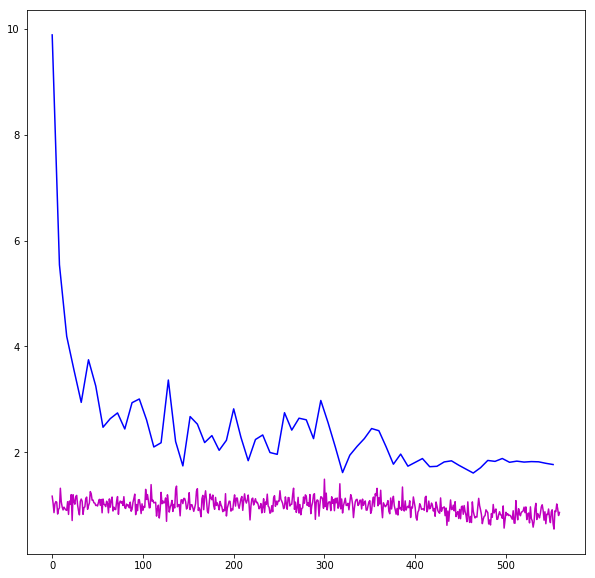

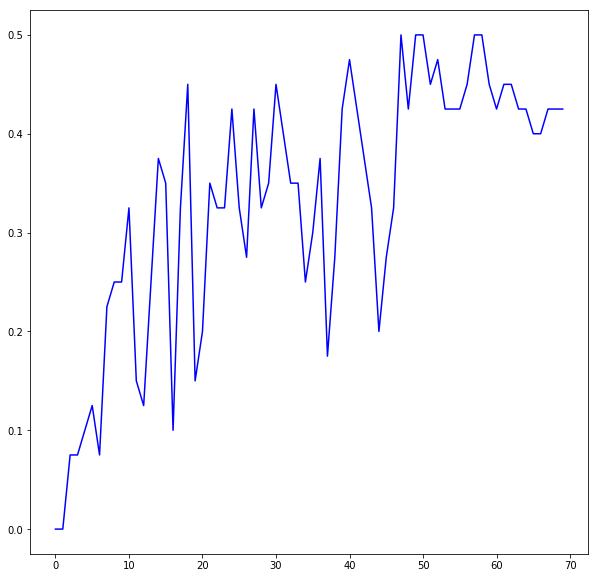

In [16]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [18]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [19]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-560
INFO:tensorflow:Restoring parameters from ./c

INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=47.ckpt-560
INFO:tensorflow:Restoring parameters fro

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


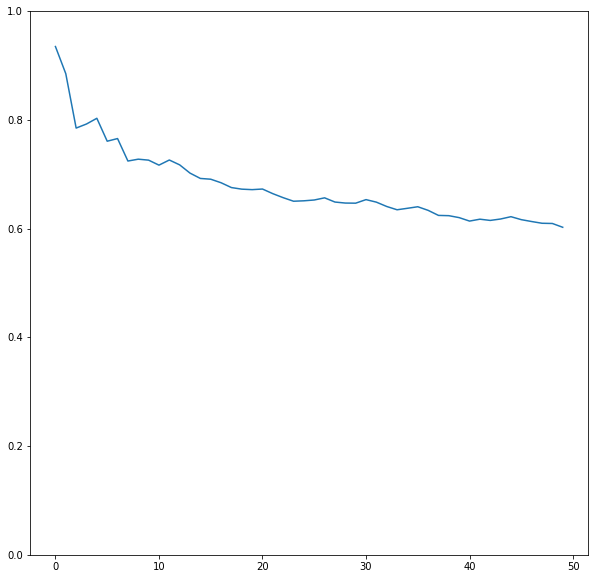

In [20]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [23]:
DB1_test_accuracies = test_accuracies
%store DB1_test_accuracies

Stored 'DB1_test_accuracies' (list)


In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()